<a href="https://colab.research.google.com/github/jeffbgreene/geology-558/blob/main/Supervised_Classification_of_Lunar_Minerals_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Classification of Lunar Minerals
#### Author: Jeff Greene
#### Date : 2/8/2025

### **Lunar Sample Data Set Description**

The data utilized in this notebook was retrieved from the website [Astromat](https://search.astromat.org/?eventId=3407). The data is a summary of chemical analysis performed on returned samples from Apollo 11, 12, 14, 15, 16 and 17. For reference, I have included a visual representation of the landing locations of each of the Apollo missions.



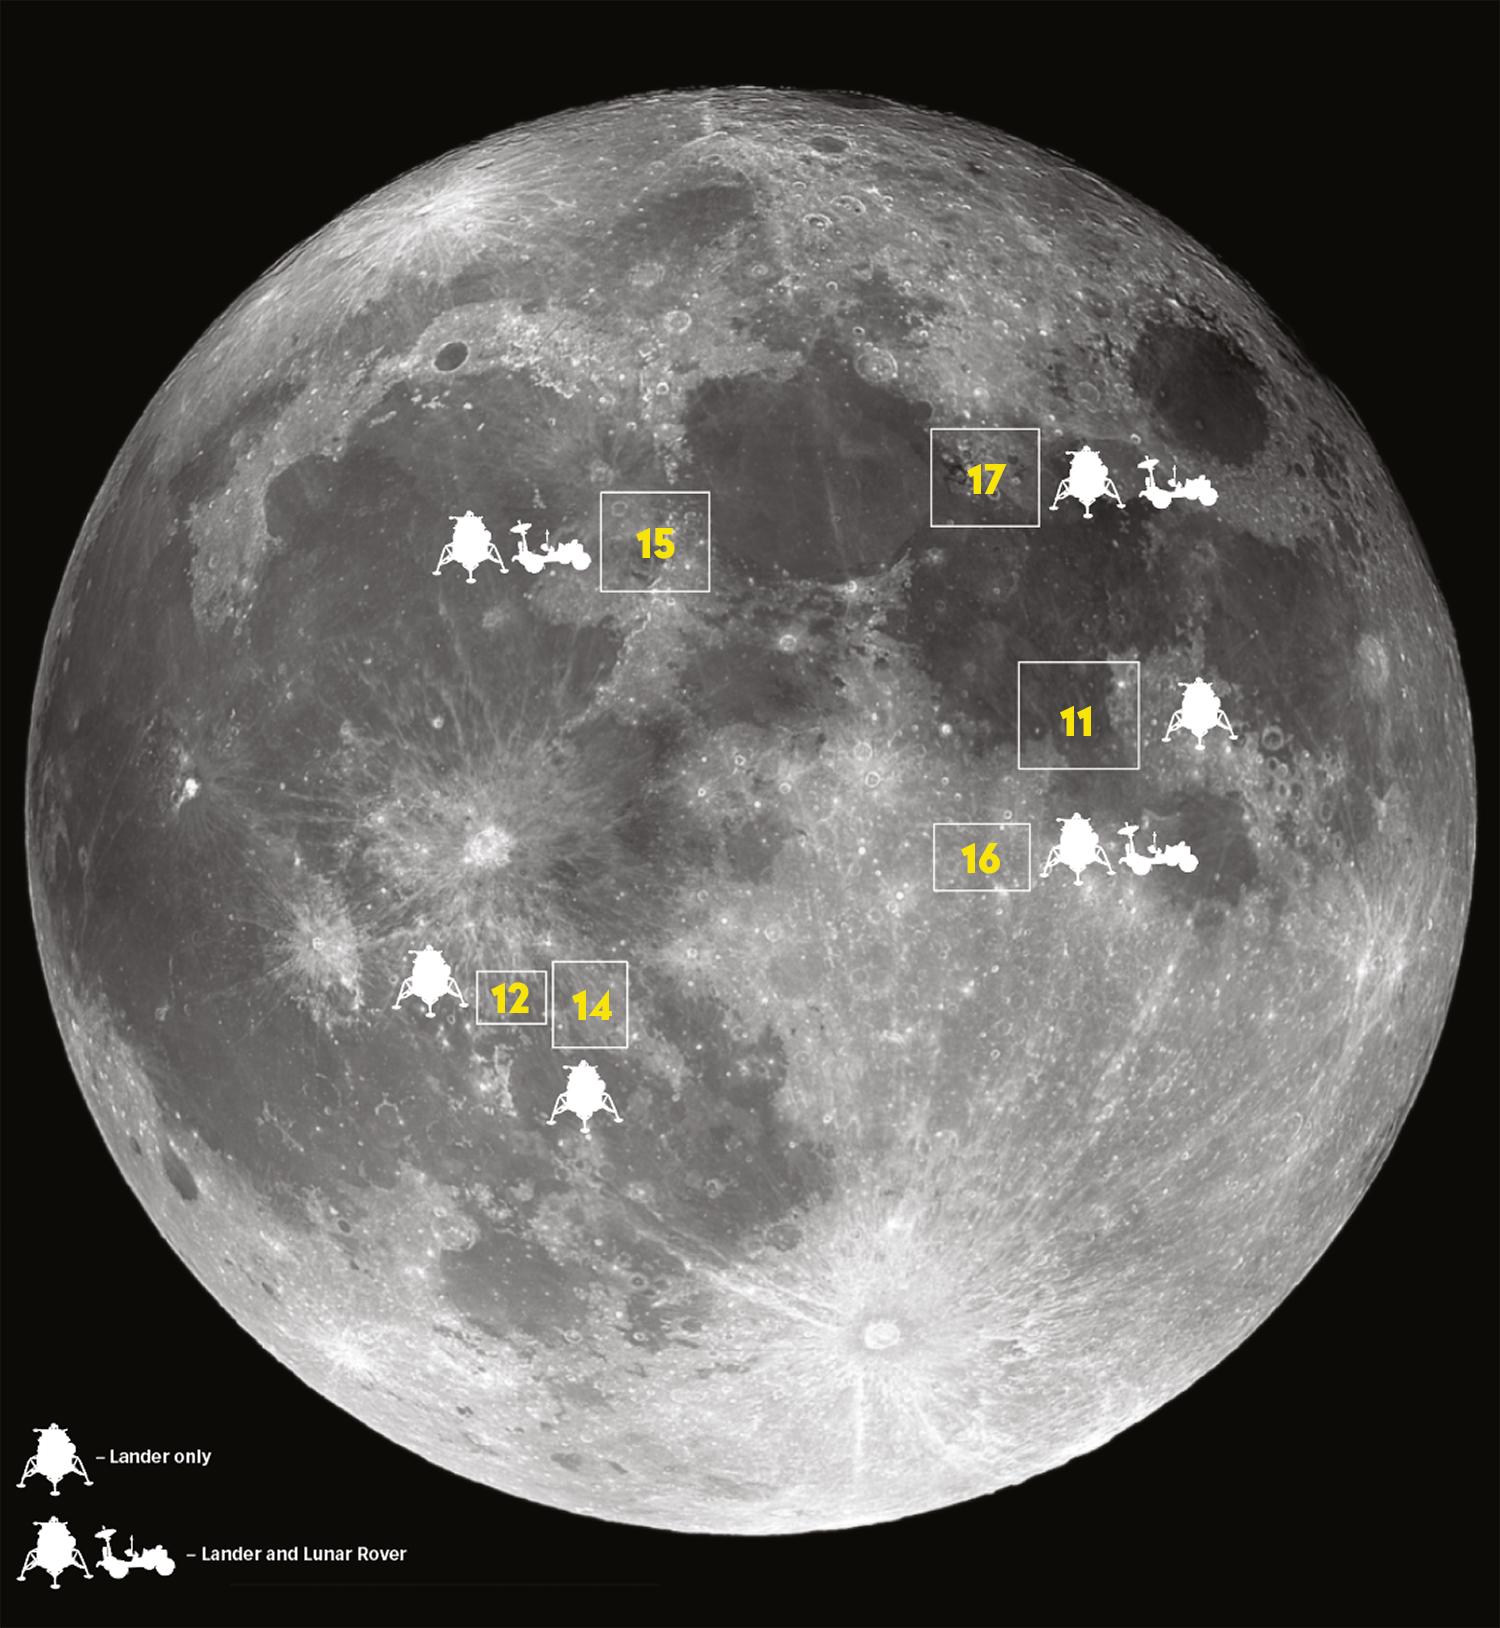



### <p style="text-align:center;"><i>Figure 1: Apollo Landing sites where Lunar samples were collected.</i></p>

### Imports

In [1]:
import os
import requests
from io import StringIO

# For preprocessing labels and splitting the data
# XGBoost and SciKit learn had a strange interaction, so I needed to add this code. This is described on
# Stack Overflow "Scikit-learn version 1.6 modified the API around its "tags", and that's the cause of this error.""
# https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

from sklearn import preprocessing
# To standardize the features
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Stats Libs
import scipy.stats as stats
from scipy.stats import pearsonr

# XGBoost
import xgboost as xgb

# Libraries for the NN
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical

## Confusion matrix and other metrics libs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

# ROC Curves
from sklearn.metrics import roc_curve, auc


Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


### Plotting function definitions

---




In [2]:
# Define a function for the confusion matrix
def plot_confusion_matrix(y_test, y_pred, algorithm_type):
  """
  Plots a confusion matrix for a given algorithm.
  """
  # Set the figure size
  plt.rcParams["figure.figsize"] = (25,25)
  # Set the default font size
  plt.rcParams.update({'font.size': 8})

  cm = confusion_matrix(y_test, y_pred)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                display_labels=classes)
  disp.plot()
  plt.title(f'Normalized Confusion Matrix for {algorithm_type} algorithm')
  plt.grid(False)
  plt.show()

In [3]:
def plot_roc_curve(y_test_bin, y_pred_proba, algorithm_type):
  """
  Plots ROC curves for a given algorithm.
  """
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(classes)):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot the ROC curves
  plt.figure()
  for i in range(len(classes)):
      plt.plot(fpr[i], tpr[i], lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(classes[i], roc_auc[i]))

  plt.plot(figsize=(10, 10))
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Multiclass ROC Curve for {algorithm_type}')
  plt.legend(loc="lower right")
  plt.show()


In [4]:
# Define function to display metrics and Classification Report
def display_metrics(y_test, y_pred, classes, algorithm_type):
  """
  Displays metrics and Classification Report for a given algorithm.
  """
  print(f'\n-------------------- {algorithm_type} Key Metrics --------------------')
  print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
  print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

  print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

  print(f'\n--------------- {algorithm_type} Classification Report ---------------\n')
  print(classification_report(y_test, y_pred, target_names=classes))

## Exploratory Data Analysis

---


The original data consists of assorted caterogorical and numerical features. Numeric values for chemical compositions in the data were derived with techniques including electron probe micro-analyzer (EMPA), although there were a variety of other techniques that were applied depending on what lab was performing the analysis.

During EDA I reduced the features in the dataset down to the 8 shown below and saved that filtered and cleaned data set to a CSV for use in this notebook. **For an in-depth look at the EDA**, please see this notebook: https://github.com/jeffbgreene/geology-558/blob/main/Supervised_Classification_EDA.ipynb

The **goal** of this notebook is to use the weight percentages of 8 different oxides as inputs to build models that can accurately predict the mineral type of unseen samples. The models were created using Logistic Regression, XGBoost and a  multi-layer perceptron or feed-foward artificial neural network.

The **features** utilized are: FeO, CaO, MgO, Al2O3, TiO2, Cr2O3, MnO, Na2O

The **classes** are: APATITE, AUGITE, ENSTATITE, FE METAL, FELDSPAR, GLASS, ILMENITE, INDETERMINATE, OLIVINE, ORTHOPYROXENE, PIGEONITE, PYRRHOTITE, SPINEL and SULFIDE

Since I am not a geologist by trade and don't really have any background in geology besides the class I took last semester and this class, I didn't really realize that some of the minerals in my data set are subtypes of others and discovered this by analyzing the misclassification seen in the confusion matrices for each model type that was seen in my original submission.

To account for some misclassifications, I relabeled and removed some of the minerals in the data set. I removed the generic Pyroxene samples, as well as
clinopyroxene, low-ca pyroxene and high-ca pyroxene. This is because several of the minerals that I used as target classes are specific types of pyroxene. I also relabeled maskelynite and plagioclase samples as feldspar to prevent models from labeling these samples differenty, as both maskelynite and plagioclase are specific types of feldspar, and maskelynite is a glassy form of plagioclase.

**Imporvements** include:
- Updated data set as described above (this code is in my EDA notebook)
- Outlier removal (this was done in the EDA notebook before imputation)
- Data Loading Validation as listed in feedback
- Feature importance analysis as described in peer review feedback
- Updated legend for Pearson Correlation Matrix to make range from 1 to -1
- Hyperparameter tuning for Logistic Regression as listed in feedback
- Inclusion of a conclusion section
- Update to questions at end of notebook


## Load the data

---

This step includes loading the data that was saved to a CSV after cleaning in the EDA notebook. As suggested in feedback, I have added steps to validate the GitHub URL and data integrity.

In [5]:
def validate_file_path_github(file_url):
    """
    Validates if a file path from GitHub URL exists.
    """
    try:
        response = requests.head(file_url)
        if response.status_code == 200:
            print(f"File path '{file_url}' exists.")
            return True
        else:
             print(f"File path '{file_url}' does not exist. Status code: {response.status_code}")
             return False
    except requests.ConnectionError as e:
        print(f"Error connecting to {file_url}: {e}")
        return False
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return False

def validate_data_integrity_github(file_url, expected_columns, expected_data_types={}):
    """
    Validates data integrity after loading from a GitHub URL.
    """
    try:
        response = requests.get(file_url)
        response.raise_for_status()
        csv_content = StringIO(response.text)
        df = pd.read_csv(csv_content)
    except requests.exceptions.RequestException as e:
         print(f"Failed to fetch data from {file_url}: {e}")
         return False
    except pd.errors.ParserError as e:
        print(f"Failed to parse CSV content: {e}")
        return False

    # Check for expected columns
    if not all(col in df.columns for col in expected_columns):
        print(f"Data does not contain all expected columns. Expected: {expected_columns}, Found: {list(df.columns)}")
        return False

     # Check for data types
    for column, expected_type in expected_data_types.items():
        if column in df.columns:
            if df[column].dtype != expected_type:
                 print(f"Column '{column}' has type {df[column].dtype}, but expected {expected_type}")
                 return False

    print("Data integrity check passed.")
    return True

In [6]:
file_url = 'https://raw.githubusercontent.com/jeffbgreene/geology-558/main/new_lunar_info.csv'
expected_columns = ['FeO', 'CaO', 'MgO', 'Al2O3', 'TiO2', 'Cr2O3', 'MnO', 'Na2O', 'Mineral']
expected_data_types = {'FeO':'float64', 'CaO':'float64', 'MgO':'float64', 'Al2O3':'float64', 'TiO2':'float64', 'Cr2O3':'float64', 'MnO':'float64', 'Na2O':'float64', 'Mineral':'object'}

if validate_file_path_github(file_url):
    if validate_data_integrity_github(file_url, expected_columns, expected_data_types):
      # Proceed with loading data
      df = pd.read_csv(file_url, index_col=None, header=0)
      print("Data has been validated and loaded")
    else:
      print("Data integrity check failed.")
else:
    # Handle file not found error
    print(f"GitHub file: {file_url} does not exist")

File path 'https://raw.githubusercontent.com/jeffbgreene/geology-558/main/new_lunar_info.csv' exists.
Data integrity check passed.
Data has been validated and loaded


In [7]:
df.head()

,FeO,CaO,MgO,Al2O3,TiO2,Cr2O3,MnO,Na2O,Mineral
0,40.70,0.210000,4.26,0.18,53.20,0.90,0.45,0.029418,ILMENITE
1,39.30,0.317568,4.55,0.00,54.60,1.03,0.33,0.029418,ILMENITE
2,38.20,0.317568,5.93,0.00,54.40,1.00,0.32,0.029418,ILMENITE
3,42.88,0.317568,2.04,0.07,53.58,1.08,0.40,0.029418,ILMENITE
4,45.02,0.317568,1.01,0.05,52.87,0.50,0.45,0.029418,ILMENITE


In [8]:
df.describe()

,FeO,CaO,MgO,Al2O3,TiO2,Cr2O3,MnO,Na2O
count,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000,54762.000000
mean,21.721879,6.997750,18.261254,9.171901,3.449602,2.253445,0.290879,0.519877
std,20.410096,11.136741,17.788399,14.344640,11.430809,8.530191,0.224999,1.268123
min,0.000000,-0.220000,-0.030000,-0.070000,-0.020000,-0.140000,-0.010000,-0.010000
25%,0.960000,0.240000,0.557460,0.196924,0.062477,0.067479,0.051812,0.053933
50%,22.400000,0.484306,16.837895,0.790000,0.093237,0.252111,0.320000,0.053933
75%,32.400000,14.600000,33.560000,12.385000,0.961885,0.487095,0.408254,0.513066
max,100.000000,57.500000,105.000000,83.390000,96.200000,74.000000,2.540000,20.060000


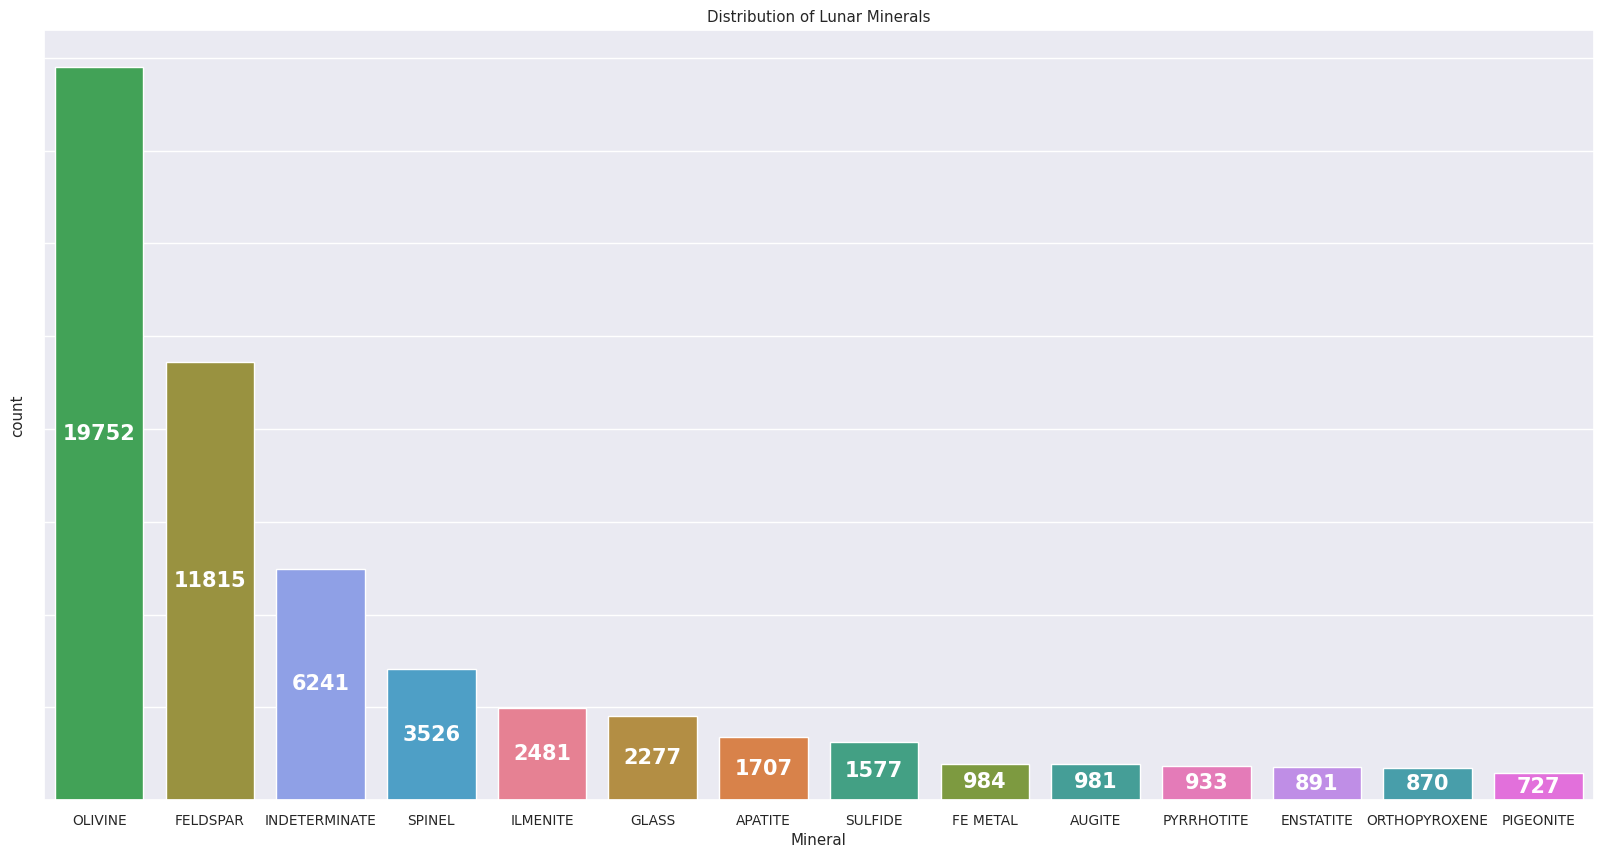

In [9]:
# Create a histogram to show mineral classes
sns.set_theme(rc={'figure.figsize':(20,10)})
sns.set(font_scale=.9)
ax = sns.countplot(x='Mineral', data=df, order=df['Mineral'].value_counts().index, hue='Mineral')
# Add count labels in the center of each bar
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{round(height)}'  # f'{height:.2f}' to format decimal values

    label_x = x + width / 2
    label_y = y + height / 2

    # Plot numric value of the stacked bar only when height is greater than specified value
    if height > 4.0:
        ax.text(label_x, label_y, label_text, color='w',
          weight='bold', ha='center', va='center', fontsize=15)


plt.title('Distribution of Lunar Minerals')
# Remove y-axis tick labels
ax.set_yticklabels([])
plt.show()

### <p style="text-align:center;"><i>Figure 2: Histogram distribution of 11 major mineral types in the Lunar samples.</i></p>

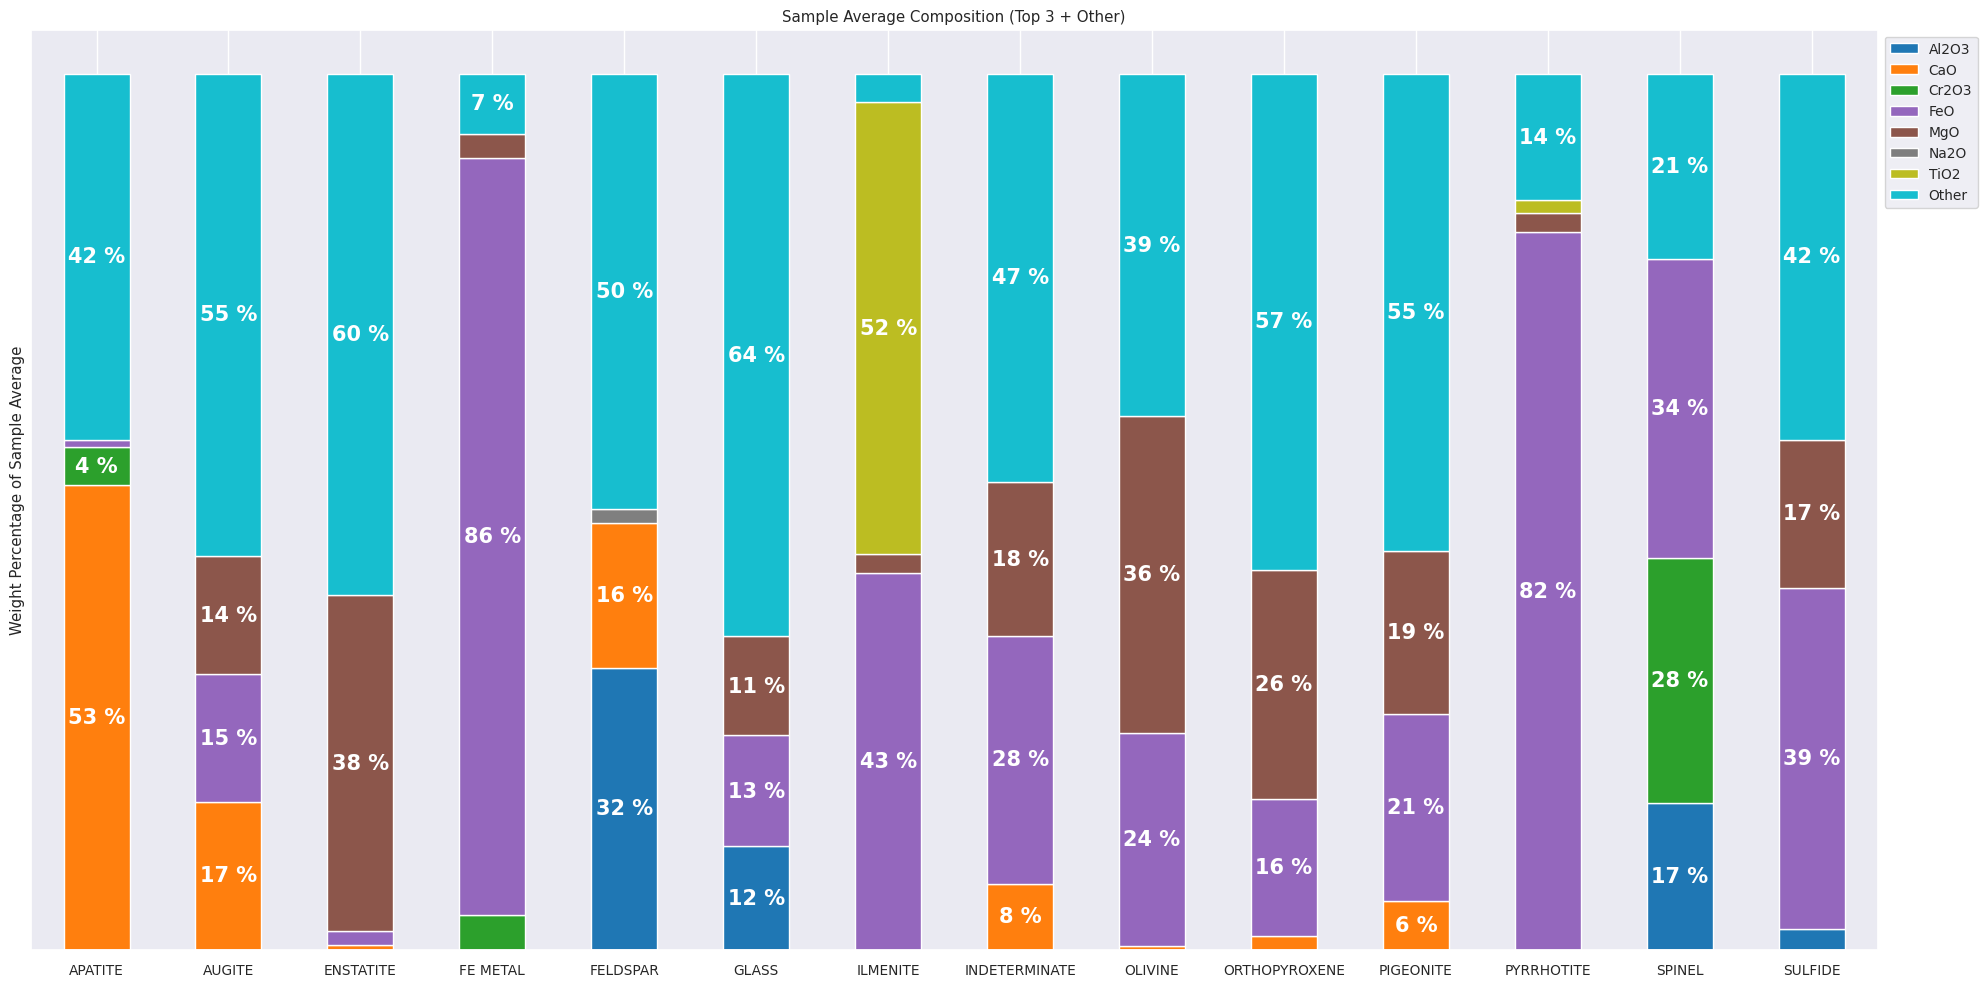

In [10]:
# Group the Samples by  mineral
# Calculate the average for the compound samples for each mineral group
grouped_df = df.groupby('Mineral', as_index=False).mean()
grouped_df.reset_index().rename(columns={df.index.name:'Mineral'})
grouped_df = grouped_df[grouped_df[['Mineral']].all(axis=1)]

# Step 1: Extract sample names some sums of row values can be performed
sample_names_op = grouped_df['Mineral']

df_compositions_op = grouped_df.drop(columns=['Mineral'])
def sum_rest(row, n_largest=3):
    largest = row.nlargest(n_largest)
    return 100 - largest.sum()

# Step 2: Get the top 3 largest values
df_top3_compositions_op = df_compositions_op.apply(lambda row: row.nlargest(3), axis=1)

# Step 3: Call the function defined above to remove the top 3 values and then return the percentage of other compounds and oxides
df_top3_compositions_op['Other'] = df_compositions_op.apply(sum_rest, axis=1)

# Step 4: Add back the 'Mineral' column
df_top3_compositions_op['Mineral'] = sample_names_op

# Step 5: Set 'Mineral' as index for plotting
df_top3_compositions_op = df_top3_compositions_op.set_index('Mineral')
# Step 6: Create the plot
# Create the subplots with two axes (one for each DataFrame)
fig, axes = plt.subplots()  # 1 row, 2 columns

# Stacked bar plot for compounds/oxides
df_top3_compositions_op.plot.bar(stacked=True, ax=axes, colormap='tab10')

for rect in axes.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The height of the bar is the data value and can be used as the label
    label_text = f'{round(height)} %'  # f'{height:.2f}' to format decimal values

    label_x = x + width / 2
    label_y = y + height / 2

    # Plot numric value of the stacked bar only when height is greater than specified value
    if height > 4.0:
        axes.text(label_x, label_y, label_text, color='w',
          weight='bold', ha='center', va='center', fontsize=15)

# Remove the y-ticks, as the numeric values are shown
plt.yticks([])
# Customize labels and titles for both subplots
axes.set_ylabel('Weight Percentage of Sample Average')
axes.set_title('Sample Average Composition (Top 3 + Other)')

# Customize x-axis labels to be each mineral name
axes.set_xlabel('')
axes.set_xticklabels(grouped_df.Mineral, rotation=0)

# relocate the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Adjust the layout to fit everything
plt.tight_layout()


# Display the plot
plt.show()

### <p style="text-align:center;"><i>Figure 3: This stacked bar plot shows the major composition of the 11 major mineral groups in Lunar samples. These values are the average for all samples for a particular group.</i></p>

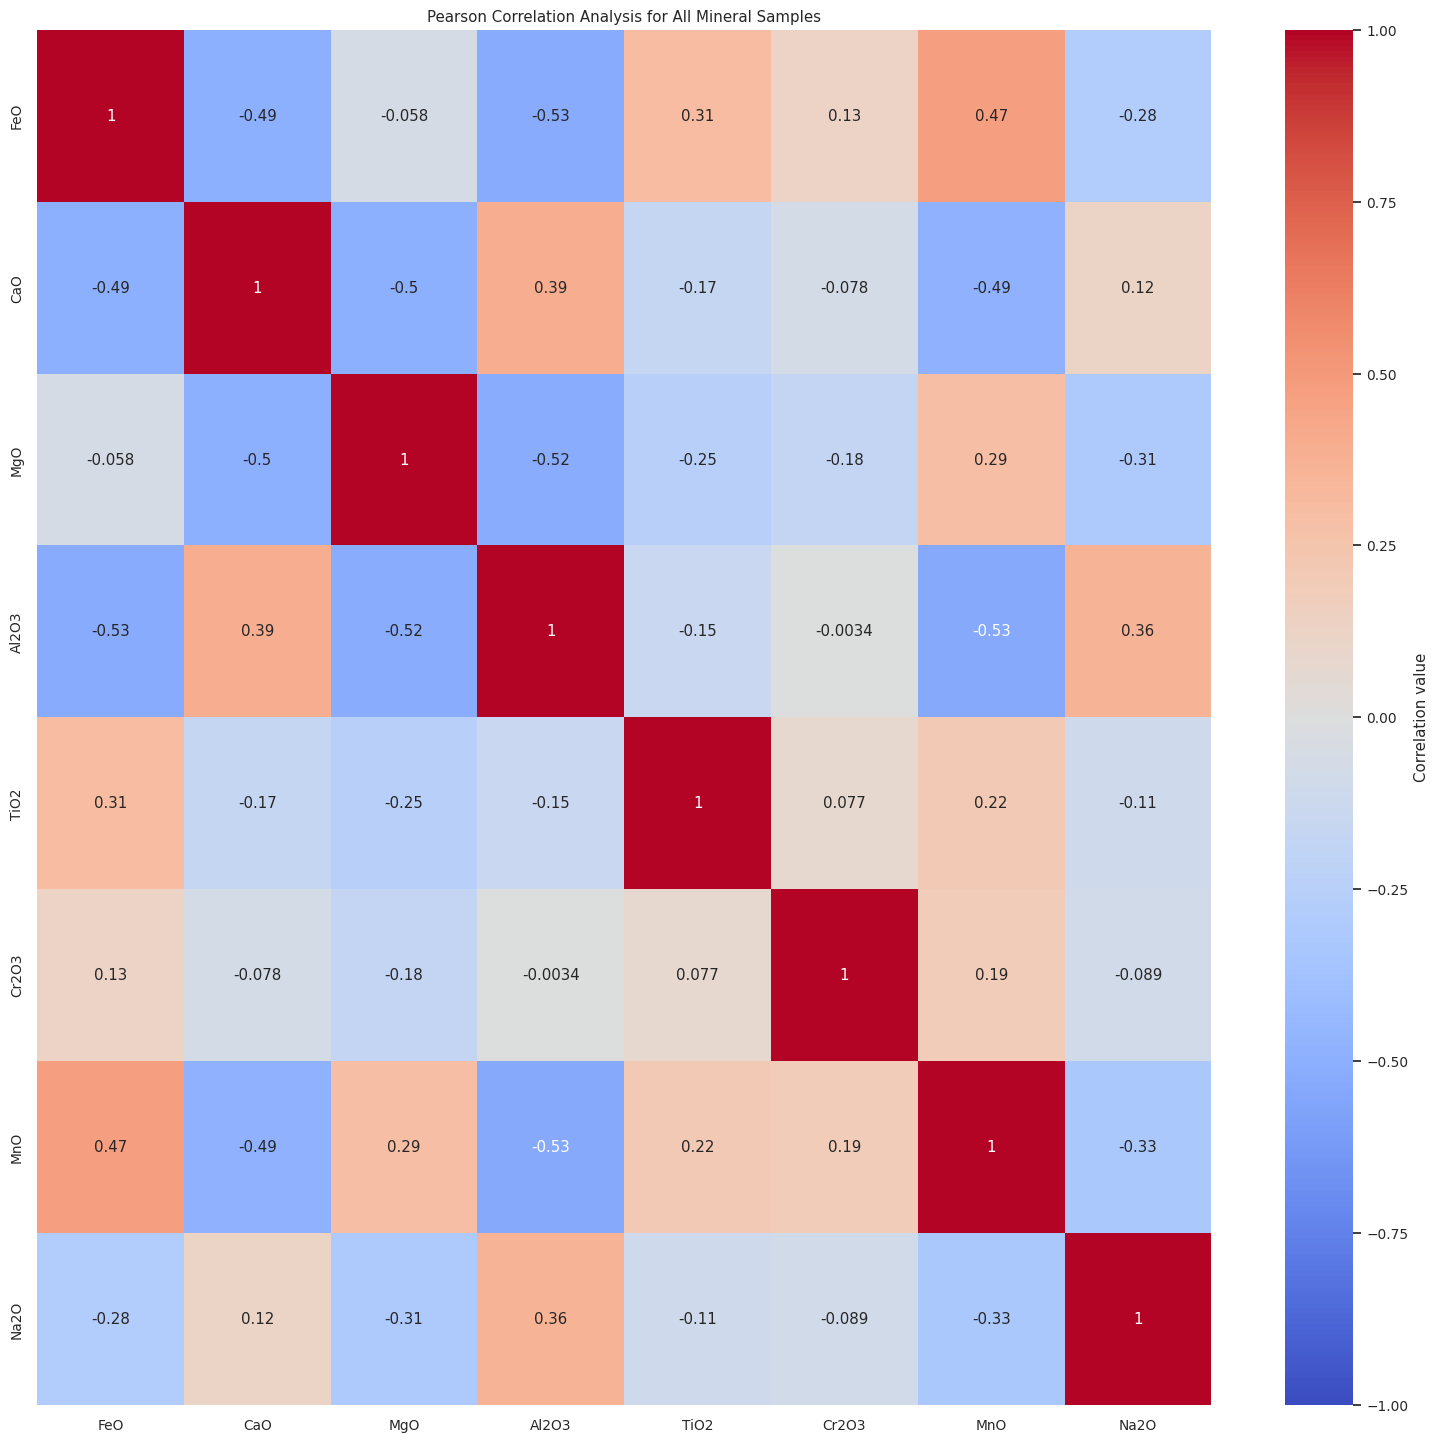

In [11]:
# Drop the Mineral column
df_rm = df.drop(['Mineral'], axis=1)

fig, ax = plt.subplots(figsize=[15, 15], sharex=True)

# Calculate the correlation matrix, dropping all NaN rows and columns
correlation_matrix = df_rm.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all')

# Plot the results of the correlation as a heatmap
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={'label': 'Correlation value'})
plt.title("Pearson Correlation Analysis for All Mineral Samples")
ax.set_position([0.55, 0.1, 0.35, 0.8])  # Adjust position manually

plt.tight_layout()
plt.show()

### <p style="text-align:center;"><i>Figure 4: Interrelationships in all samples were assessed by Pearson correlation analysis. Multiple moderate correlations were observed.</i></p>

### Preprocessing


---

The mineral names cannot be used directly as the target for the various algorithms. Instead, the minerals names must be numerically encoded. I did this using the SciKit Learn LabelEncoder class. I also saved off the unique Mineral names as a list and dictionary if I needed to utilize them later

In [12]:
# Encode the Labels
le = preprocessing.LabelEncoder()
le.fit(df['Mineral'])
classes = le.classes_
class_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df['Mineral']=le.transform(df['Mineral'])

# Sanity check to ensure that the Target classes were encoded properly
df.head()

,FeO,CaO,MgO,Al2O3,TiO2,Cr2O3,MnO,Na2O,Mineral
0,40.70,0.210000,4.26,0.18,53.20,0.90,0.45,0.029418,6
1,39.30,0.317568,4.55,0.00,54.60,1.03,0.33,0.029418,6
2,38.20,0.317568,5.93,0.00,54.40,1.00,0.32,0.029418,6
3,42.88,0.317568,2.04,0.07,53.58,1.08,0.40,0.029418,6
4,45.02,0.317568,1.01,0.05,52.87,0.50,0.45,0.029418,6


In [13]:
# Sanity check off the class list and dictionary I created in the previous cell
print(classes)
print(class_name_mapping)

['APATITE' 'AUGITE' 'ENSTATITE' 'FE METAL' 'FELDSPAR' 'GLASS' 'ILMENITE'
 'INDETERMINATE' 'OLIVINE' 'ORTHOPYROXENE' 'PIGEONITE' 'PYRRHOTITE'
 'SPINEL' 'SULFIDE']
{'APATITE': 0, 'AUGITE': 1, 'ENSTATITE': 2, 'FE METAL': 3, 'FELDSPAR': 4, 'GLASS': 5, 'ILMENITE': 6, 'INDETERMINATE': 7, 'OLIVINE': 8, 'ORTHOPYROXENE': 9, 'PIGEONITE': 10, 'PYRRHOTITE': 11, 'SPINEL': 12, 'SULFIDE': 13}


### Create the Feature and Target Vectors


---

In the next cell I set the variable X as the feature vectors to be utilized in the split step. The target variable is also set with the encoded numeric value for each mineral class. Because the neural network expects the encoded numeric value to be one-hot encoded, I performed that step here as well and saved those values in a different variable.

In [14]:
# Set the Feature Vectors
X = df.drop('Mineral', axis=1)
# Set the target variables
y = df['Mineral']

# One-hot encode target variables as that is the required input for the Neural Network
y_ohe = to_categorical(y, num_classes=len(classes)) # Assuming 10 classes

### Splitting the Data


---
Because of the class imbalance that can be see in the EDA above, I performed a Stratified Split on the data.


In [15]:
# Stratified split of train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create StratifiedShuffleSplit object
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform stratified splitting
for train_index, val_index in stratified_splitter.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

Fit the training data with the scaler, and then transform the validation and test data to prevent bias

In [16]:
#Standardize the feature vectors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Feature importance analysis


---

As suggested in feedback, I will use the Random Forest algorithm to determine the feature importance for my data set



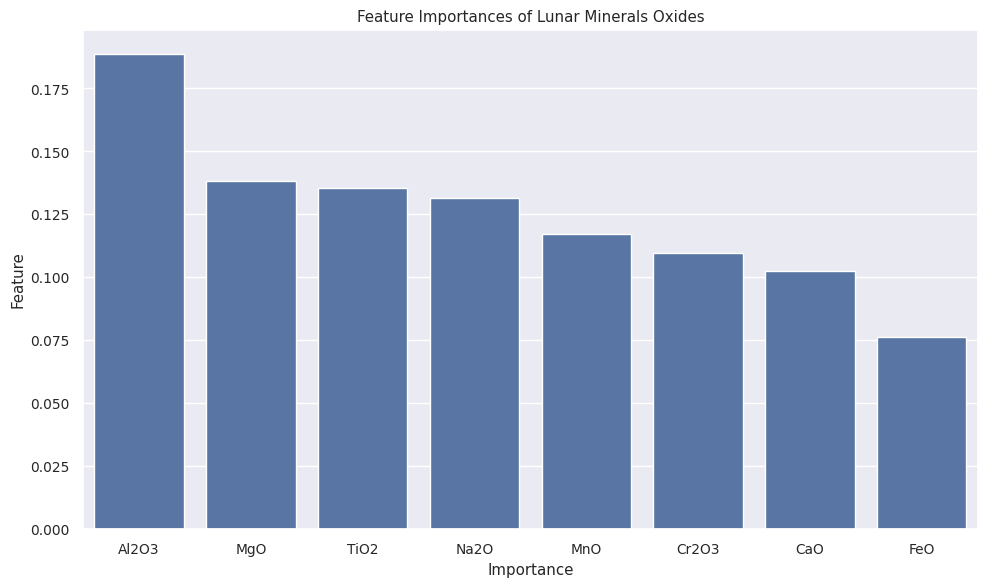

In [17]:
features = list(X.columns)
# Create a Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
# Use feature_importances DataFrame instead of df
ax = sns.barplot(x='Feature', y='Importance', data=feature_importances)
plt.title('Feature Importances of Lunar Minerals Oxides')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### <p style="text-align:center;"><i>Figure 5: Using a Random Forest Classifier, Feature importance has been determined for the data set.</i></p>

# Logistic Regression

---

I used the vanilla algorithm first, then attempted to tune the hyperparameters for Logistic Regression using Grid Search.

In [18]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Calculate training loss
y_train_pred = logreg.predict_proba(X_train)
train_loss = log_loss(y_train, y_train_pred)

# Calculate training accuracy
y_train_pred_labels = logreg.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred_labels)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)

Training Loss: 0.2854146247862728
Training Accuracy: 0.9263297941721232


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


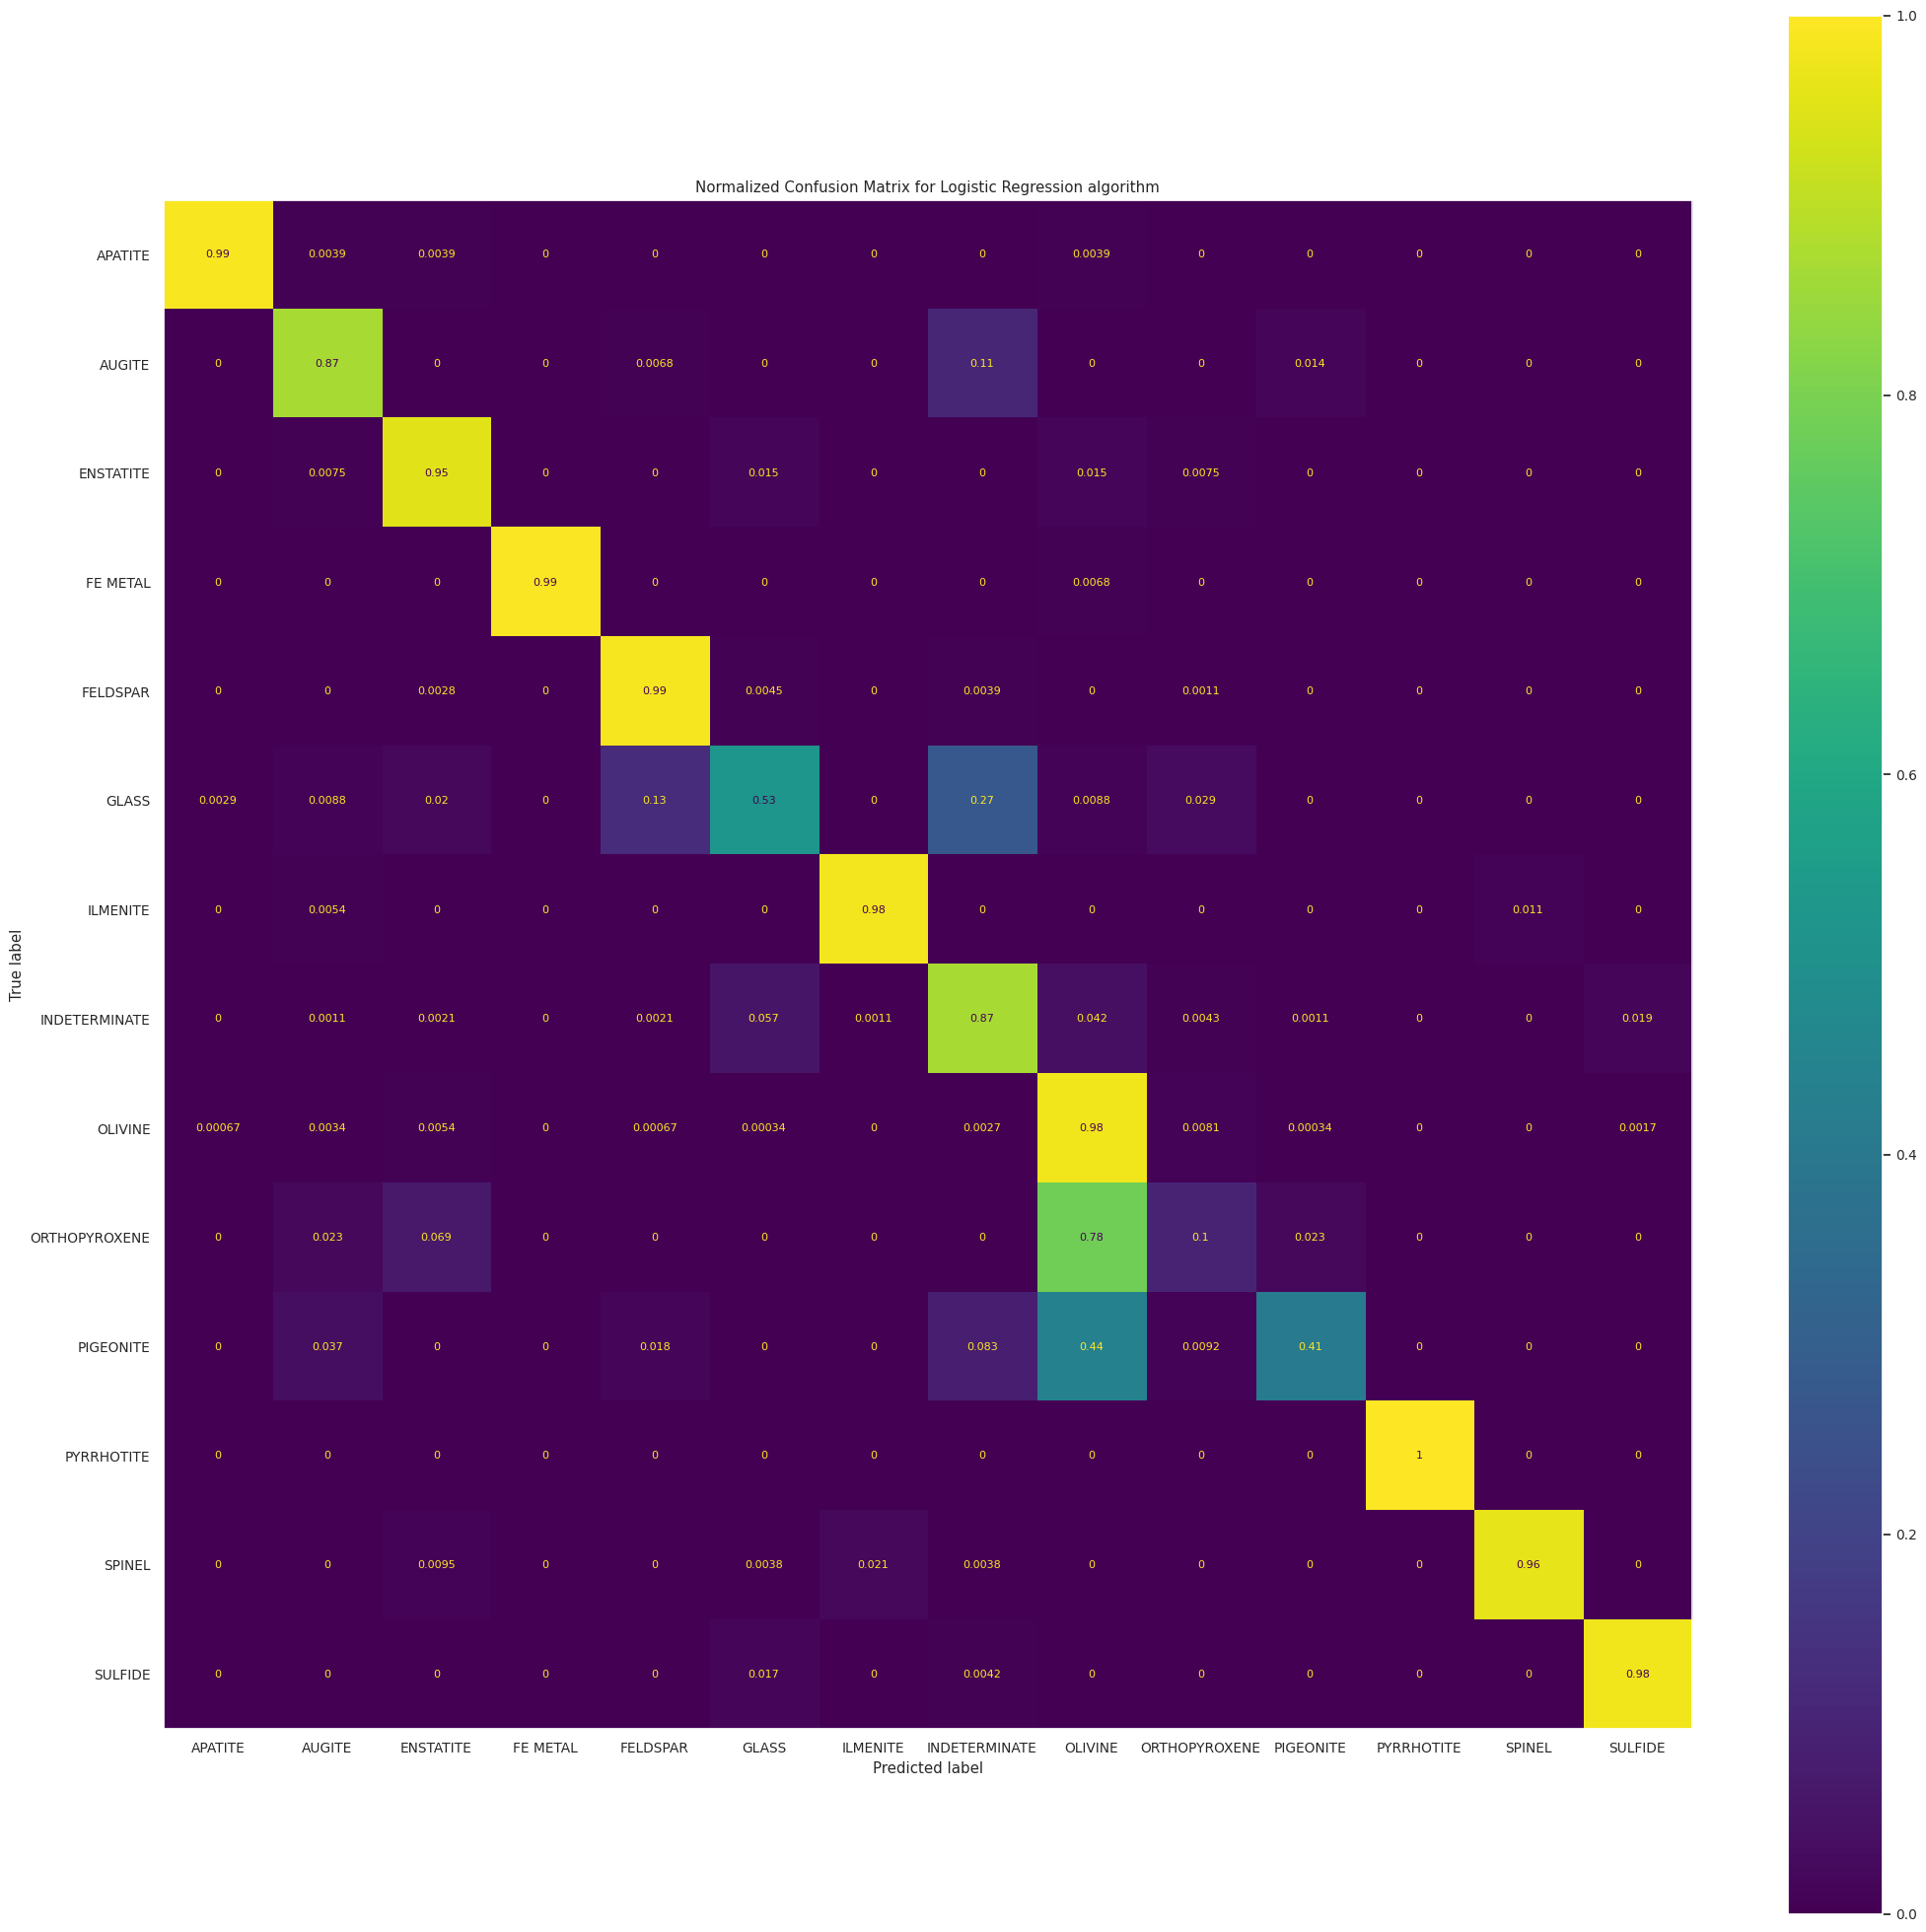

In [19]:
y_pred = logreg.predict(X_test)
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression')

### <p style="text-align:center;"><i>Figure 6: The Confusion Matrix for Logistic Regression shows that the model is pretty accurate for most classes. It appears that there are some issues with glass, orthopyroxene and piegeonite. However, the classifier did really well with all other classes.</i></p>

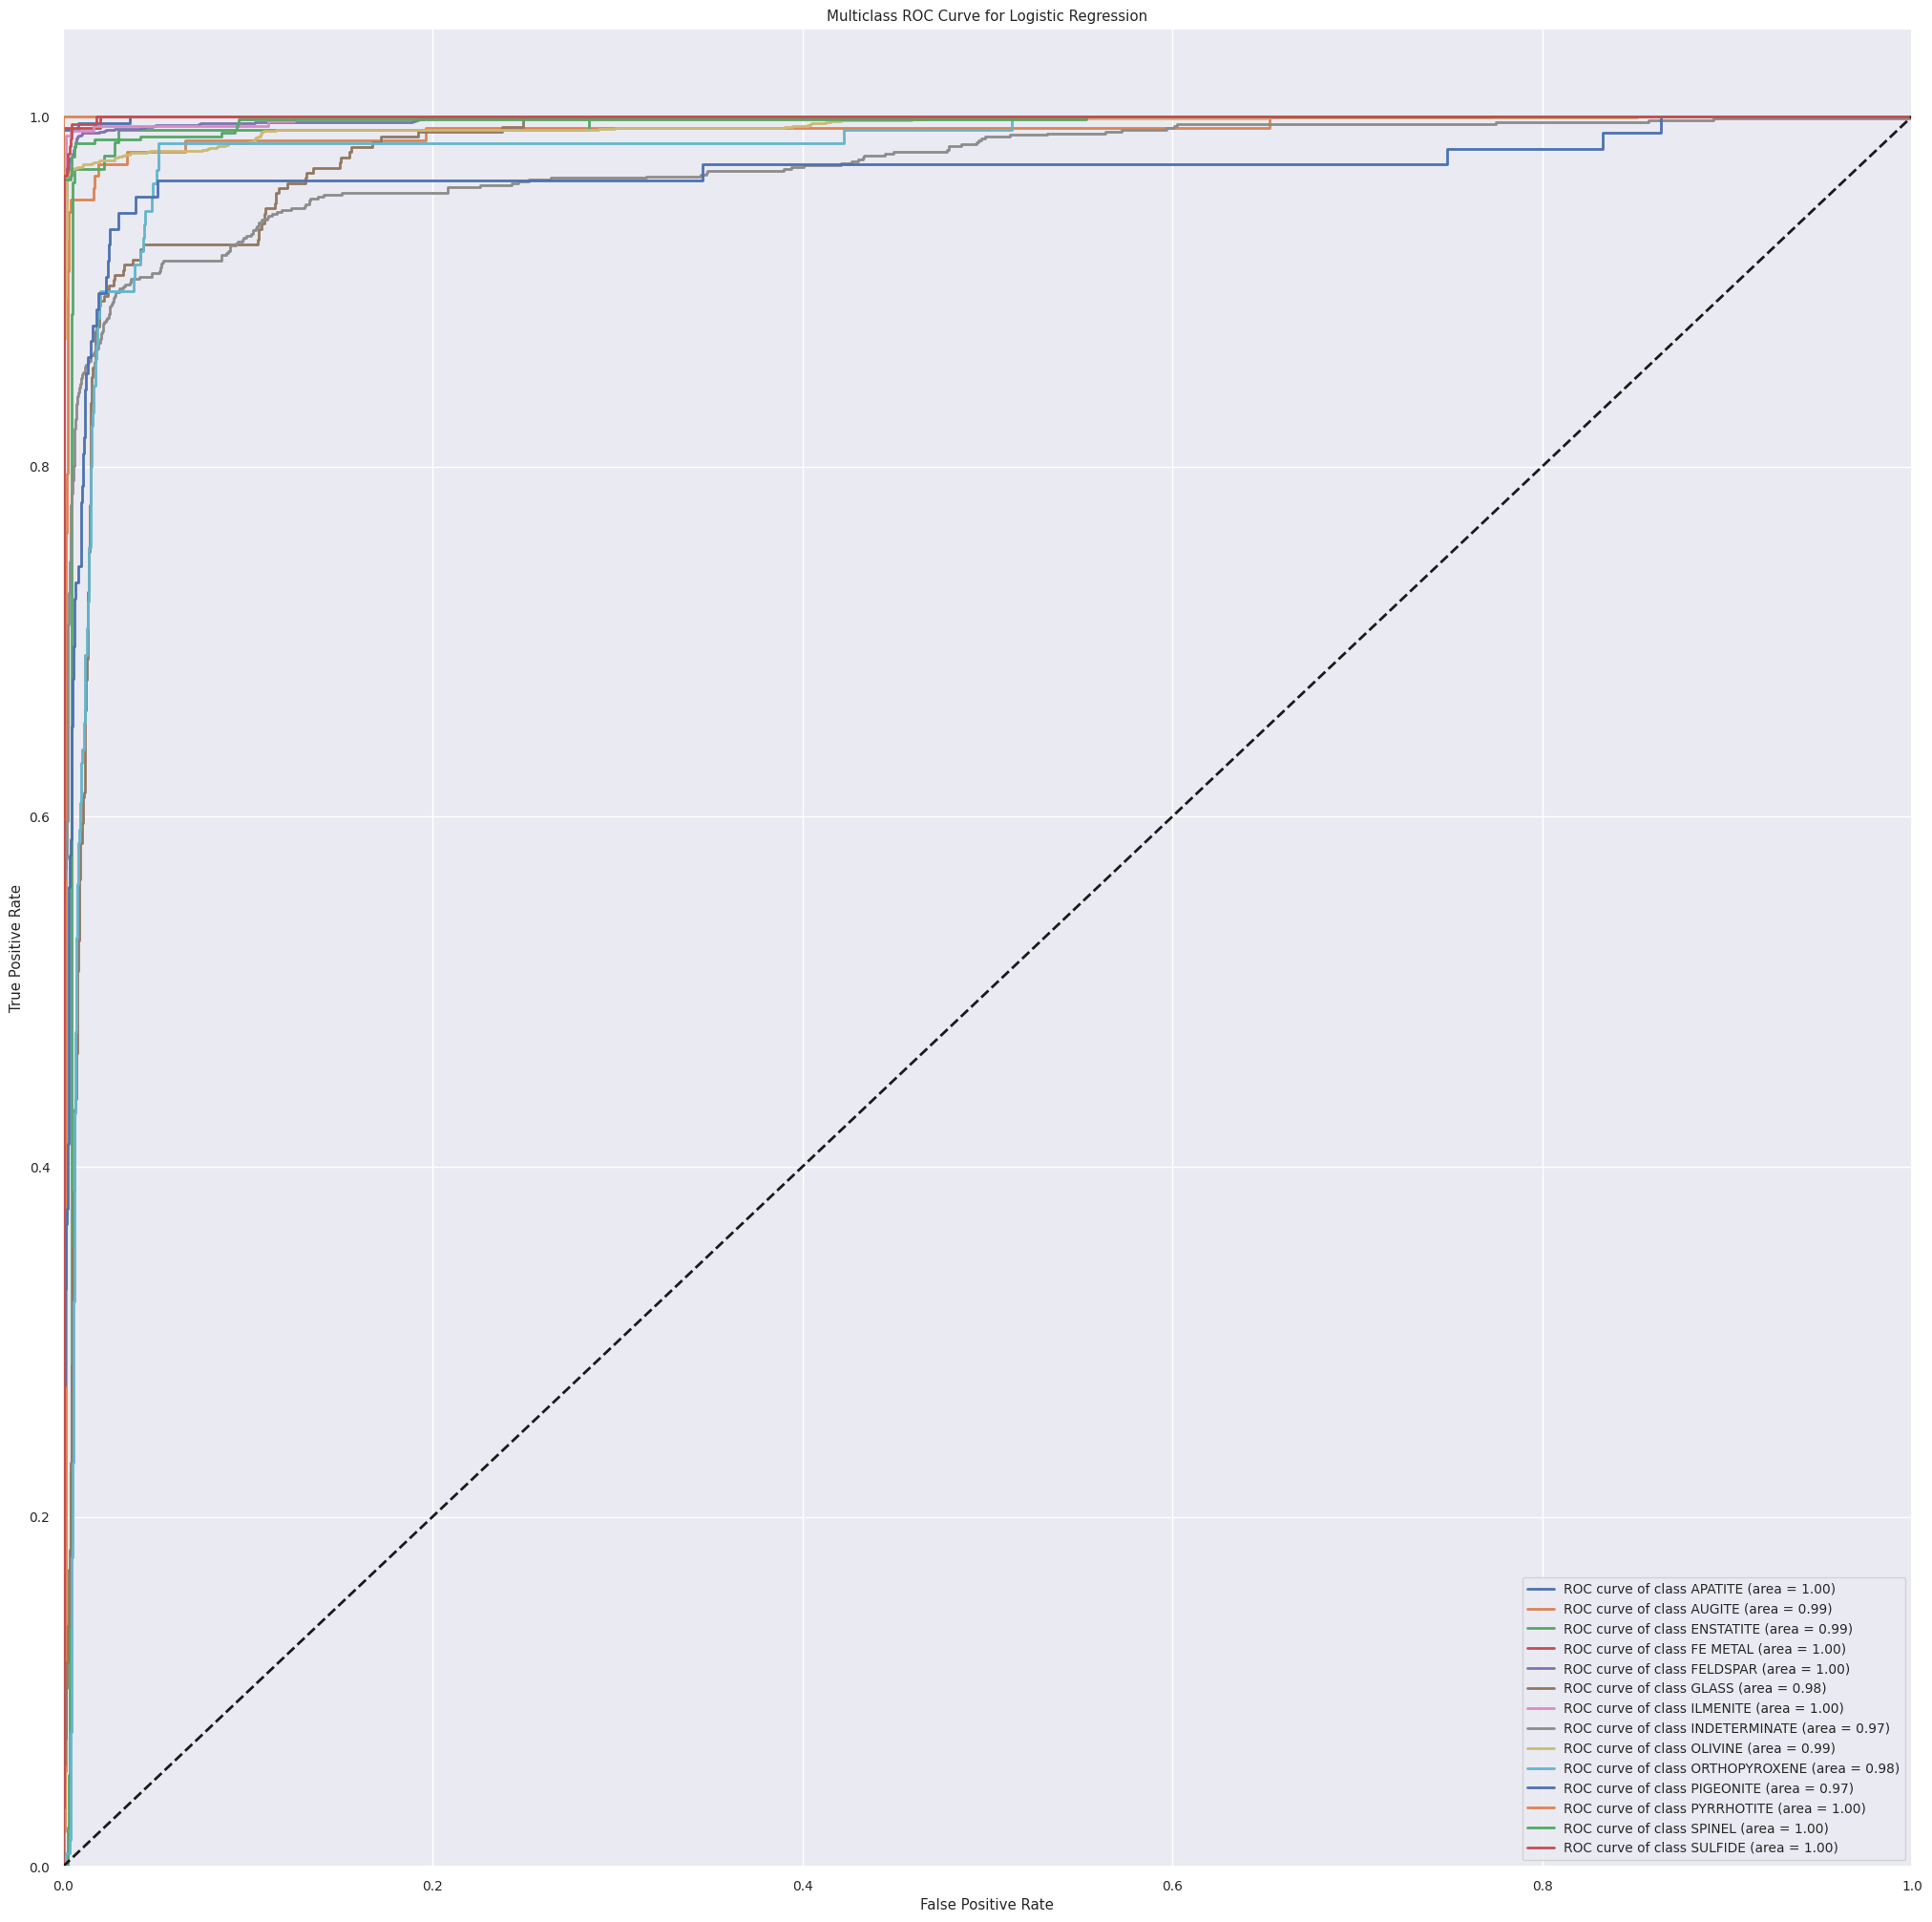

In [20]:
y_test_bin = label_binarize(y_test, classes=list(class_name_mapping.values()))

# Get predicted probabilities for each class
y_pred_proba = logreg.predict_proba(X_test)

plot_roc_curve(y_test_bin, y_pred_proba, 'Logistic Regression')

### <p style="text-align:center;"><i>Figure 7: ROC curves and AUC calculations for the Logistic Regression model</i></p>

In [21]:
display_metrics(y_test, y_pred, classes, 'Logistic Regression')


-------------------- Logistic Regression Key Metrics --------------------

Accuracy: 0.93
Balanced Accuracy: 0.83

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.86
Macro Recall: 0.83
Macro F1-score: 0.83

Weighted Precision: 0.92
Weighted Recall: 0.93
Weighted F1-score: 0.92

--------------- Logistic Regression Classification Report ---------------

               precision    recall  f1-score   support

      APATITE       0.99      0.99      0.99       256
       AUGITE       0.84      0.87      0.85       147
    ENSTATITE       0.74      0.95      0.83       133
     FE METAL       1.00      0.99      1.00       147
     FELDSPAR       0.97      0.99      0.98      1773
        GLASS       0.72      0.53      0.61       342
     ILMENITE       0.97      0.98      0.98       372
INDETERMINATE       0.86      0.87      0.86       937
      OLIVINE       0.94      0.98      0.96      2963
ORTHOPYROXENE       0.24      0.10      0.14       130
    P

### Logistic Regression Hyperparameter Tuning
I tried some different values for some of Logistic Regression hyperparameters. Because the GridSearch algorithm takes a while to run, I commented out the code and included the best set of hyperparameters in Markdown below the cell.

In [22]:
 # Hyperparameters for GridSearch tuning
 param_grid = {
    'penalty':['l1','l2'],
    'C' : [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs','newton-cg','liblinear','saga'],
   }

In [23]:
# This code takes an extremely long time to run, so I have commented it out and included the results in Markdown below
'''
%%time
logreg = LogisticRegression(random_state=42)
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
'''

"\n%%time\nlogreg = LogisticRegression(random_state=42)\ngrid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro') \ngrid_search.fit(X_train, y_train)\nprint(grid_search.best_params_)\nbest_model = grid_search.best_estimator_\ntest_accuracy = best_model.score(X_test, y_test)\n"

The best hyperparameters were: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}

In [24]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=42, C= 1, penalty='l1', solver= 'saga')
logreg.fit(X_train, y_train)

# Calculate training loss
y_train_pred = logreg.predict_proba(X_train)
train_loss = log_loss(y_train, y_train_pred)

# Calculate training accuracy
y_train_pred_labels = logreg.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred_labels)

print("Training Loss after tuning:", train_loss)
print("Training Accuracy after tuning:", train_accuracy)

Training Loss after tuning: 0.28385658007322984
Training Accuracy after tuning: 0.9273993686901625


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


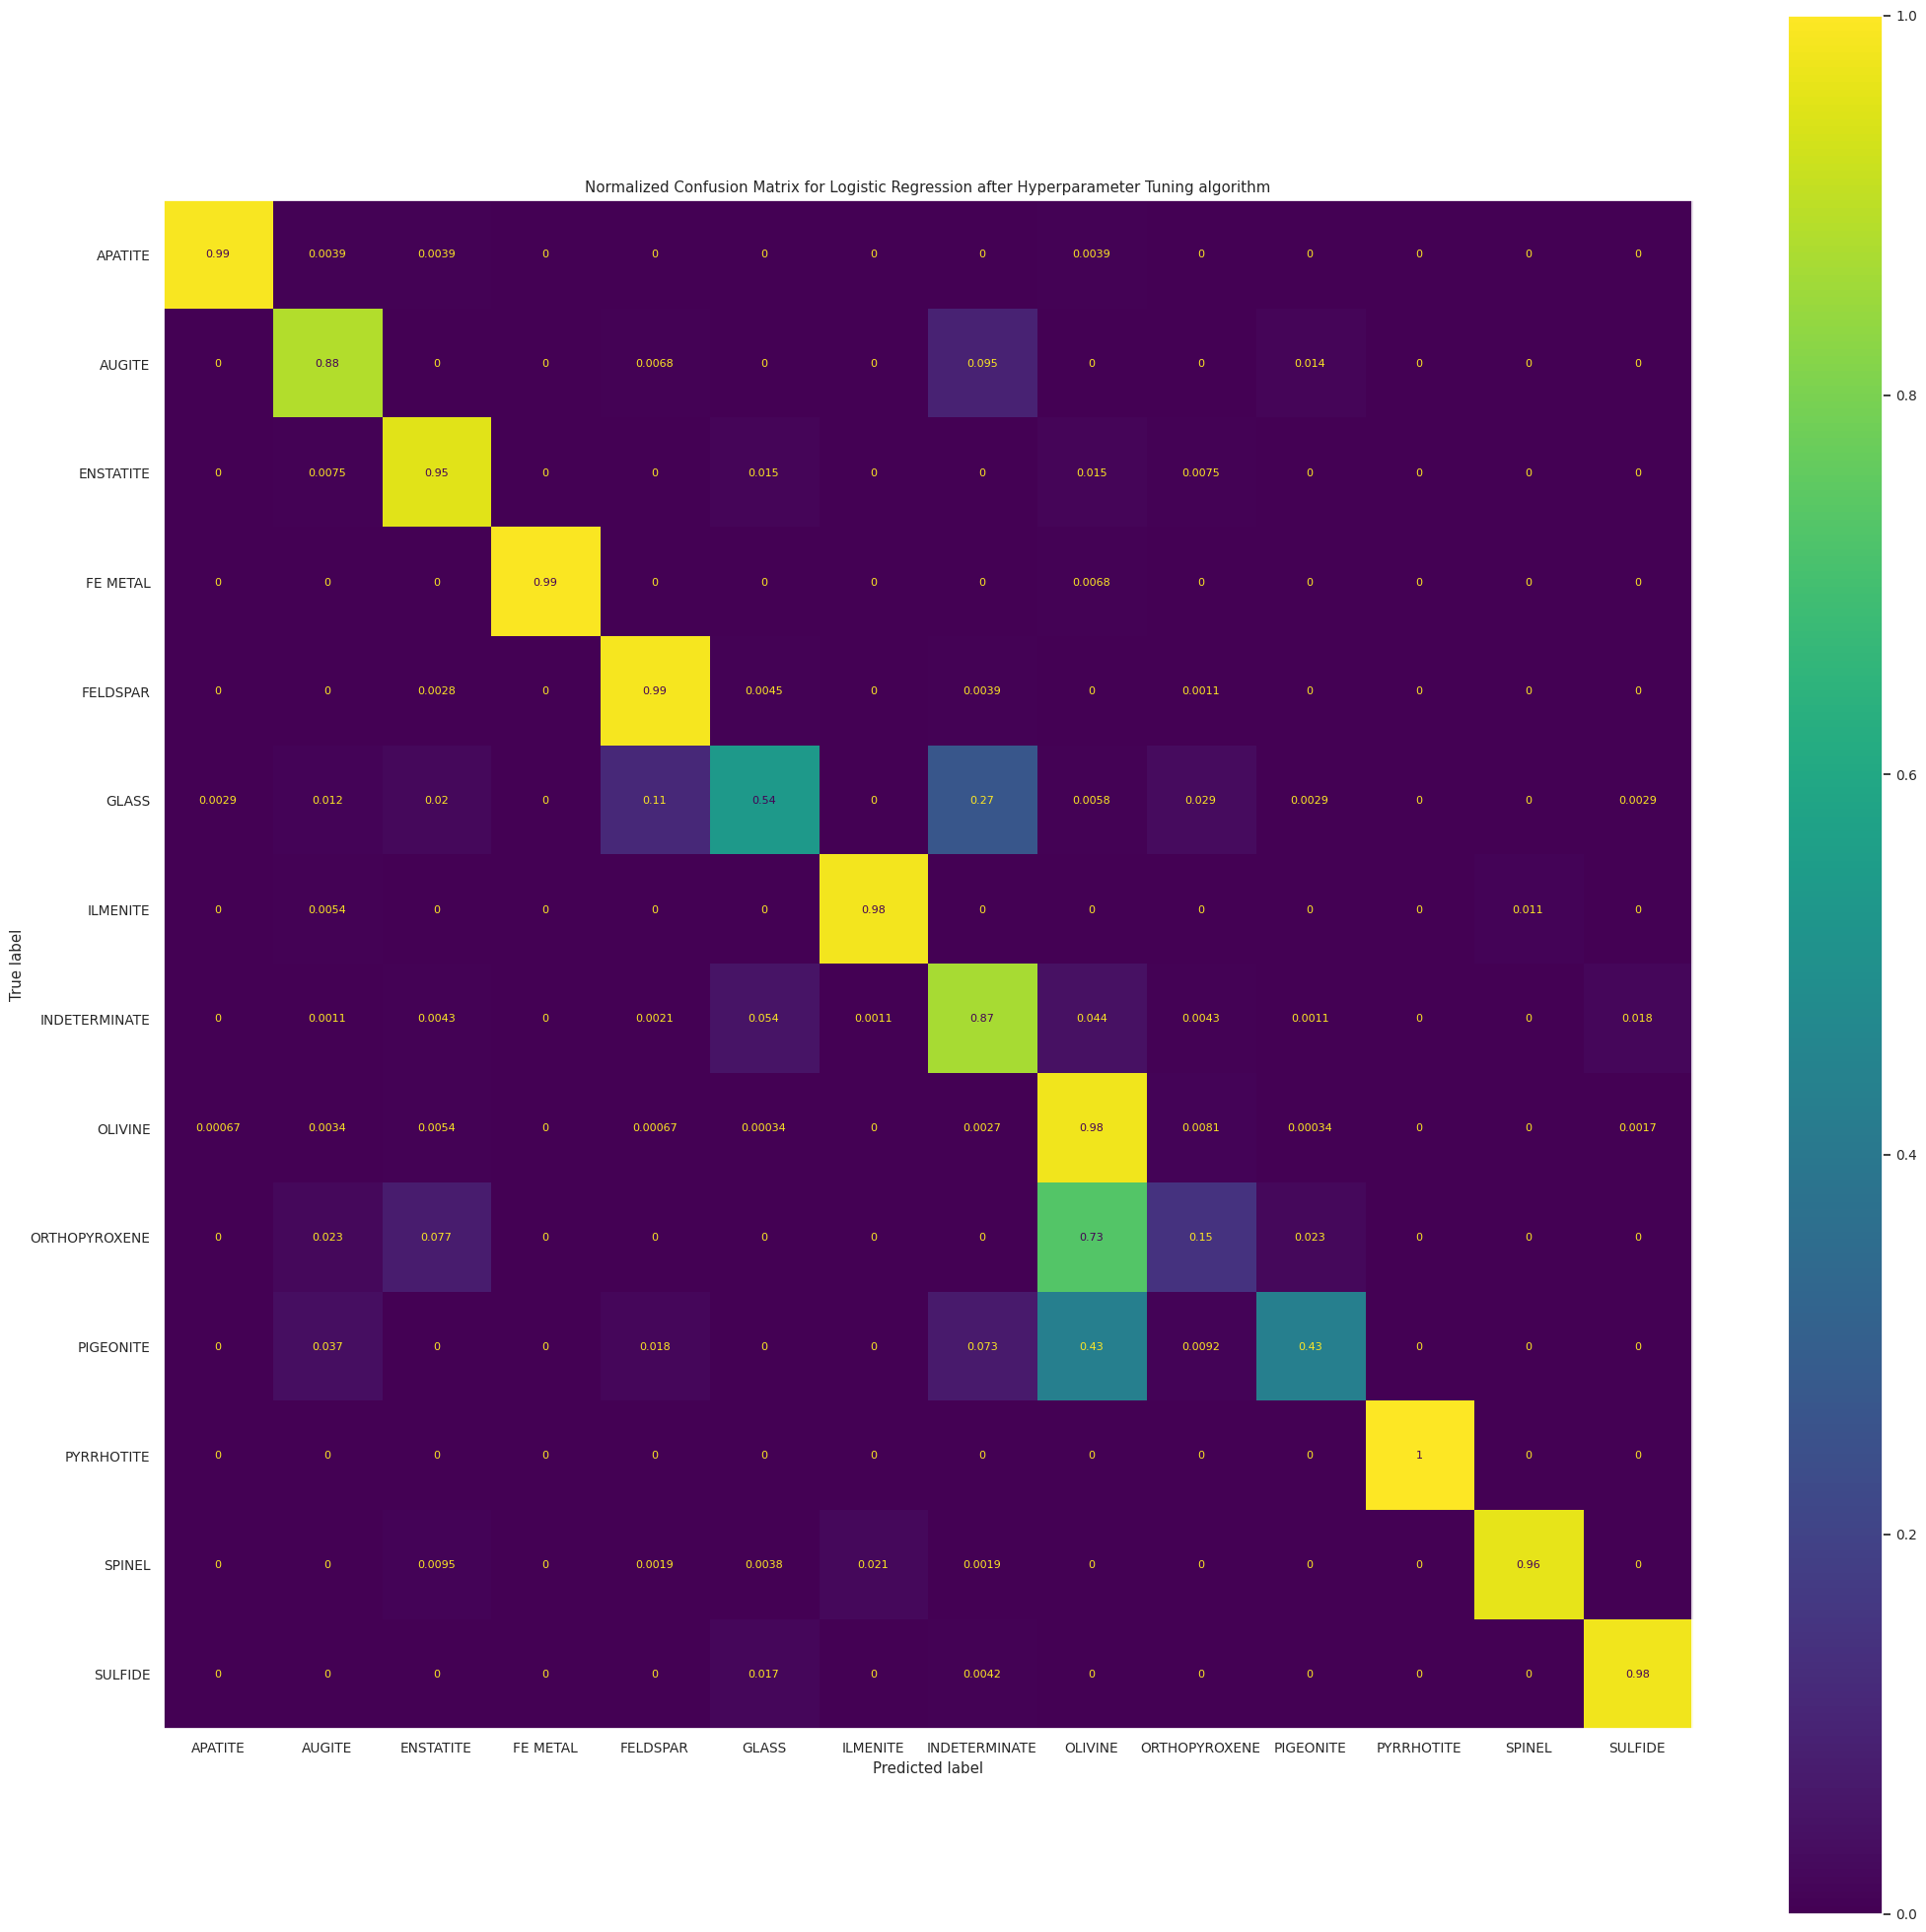

In [25]:
y_pred = logreg.predict(X_test)
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression after Hyperparameter Tuning')

### <p style="text-align:center;"><i>Figure 8: Much like the previous CM, this model had the same issues with the same classes.</i></p>

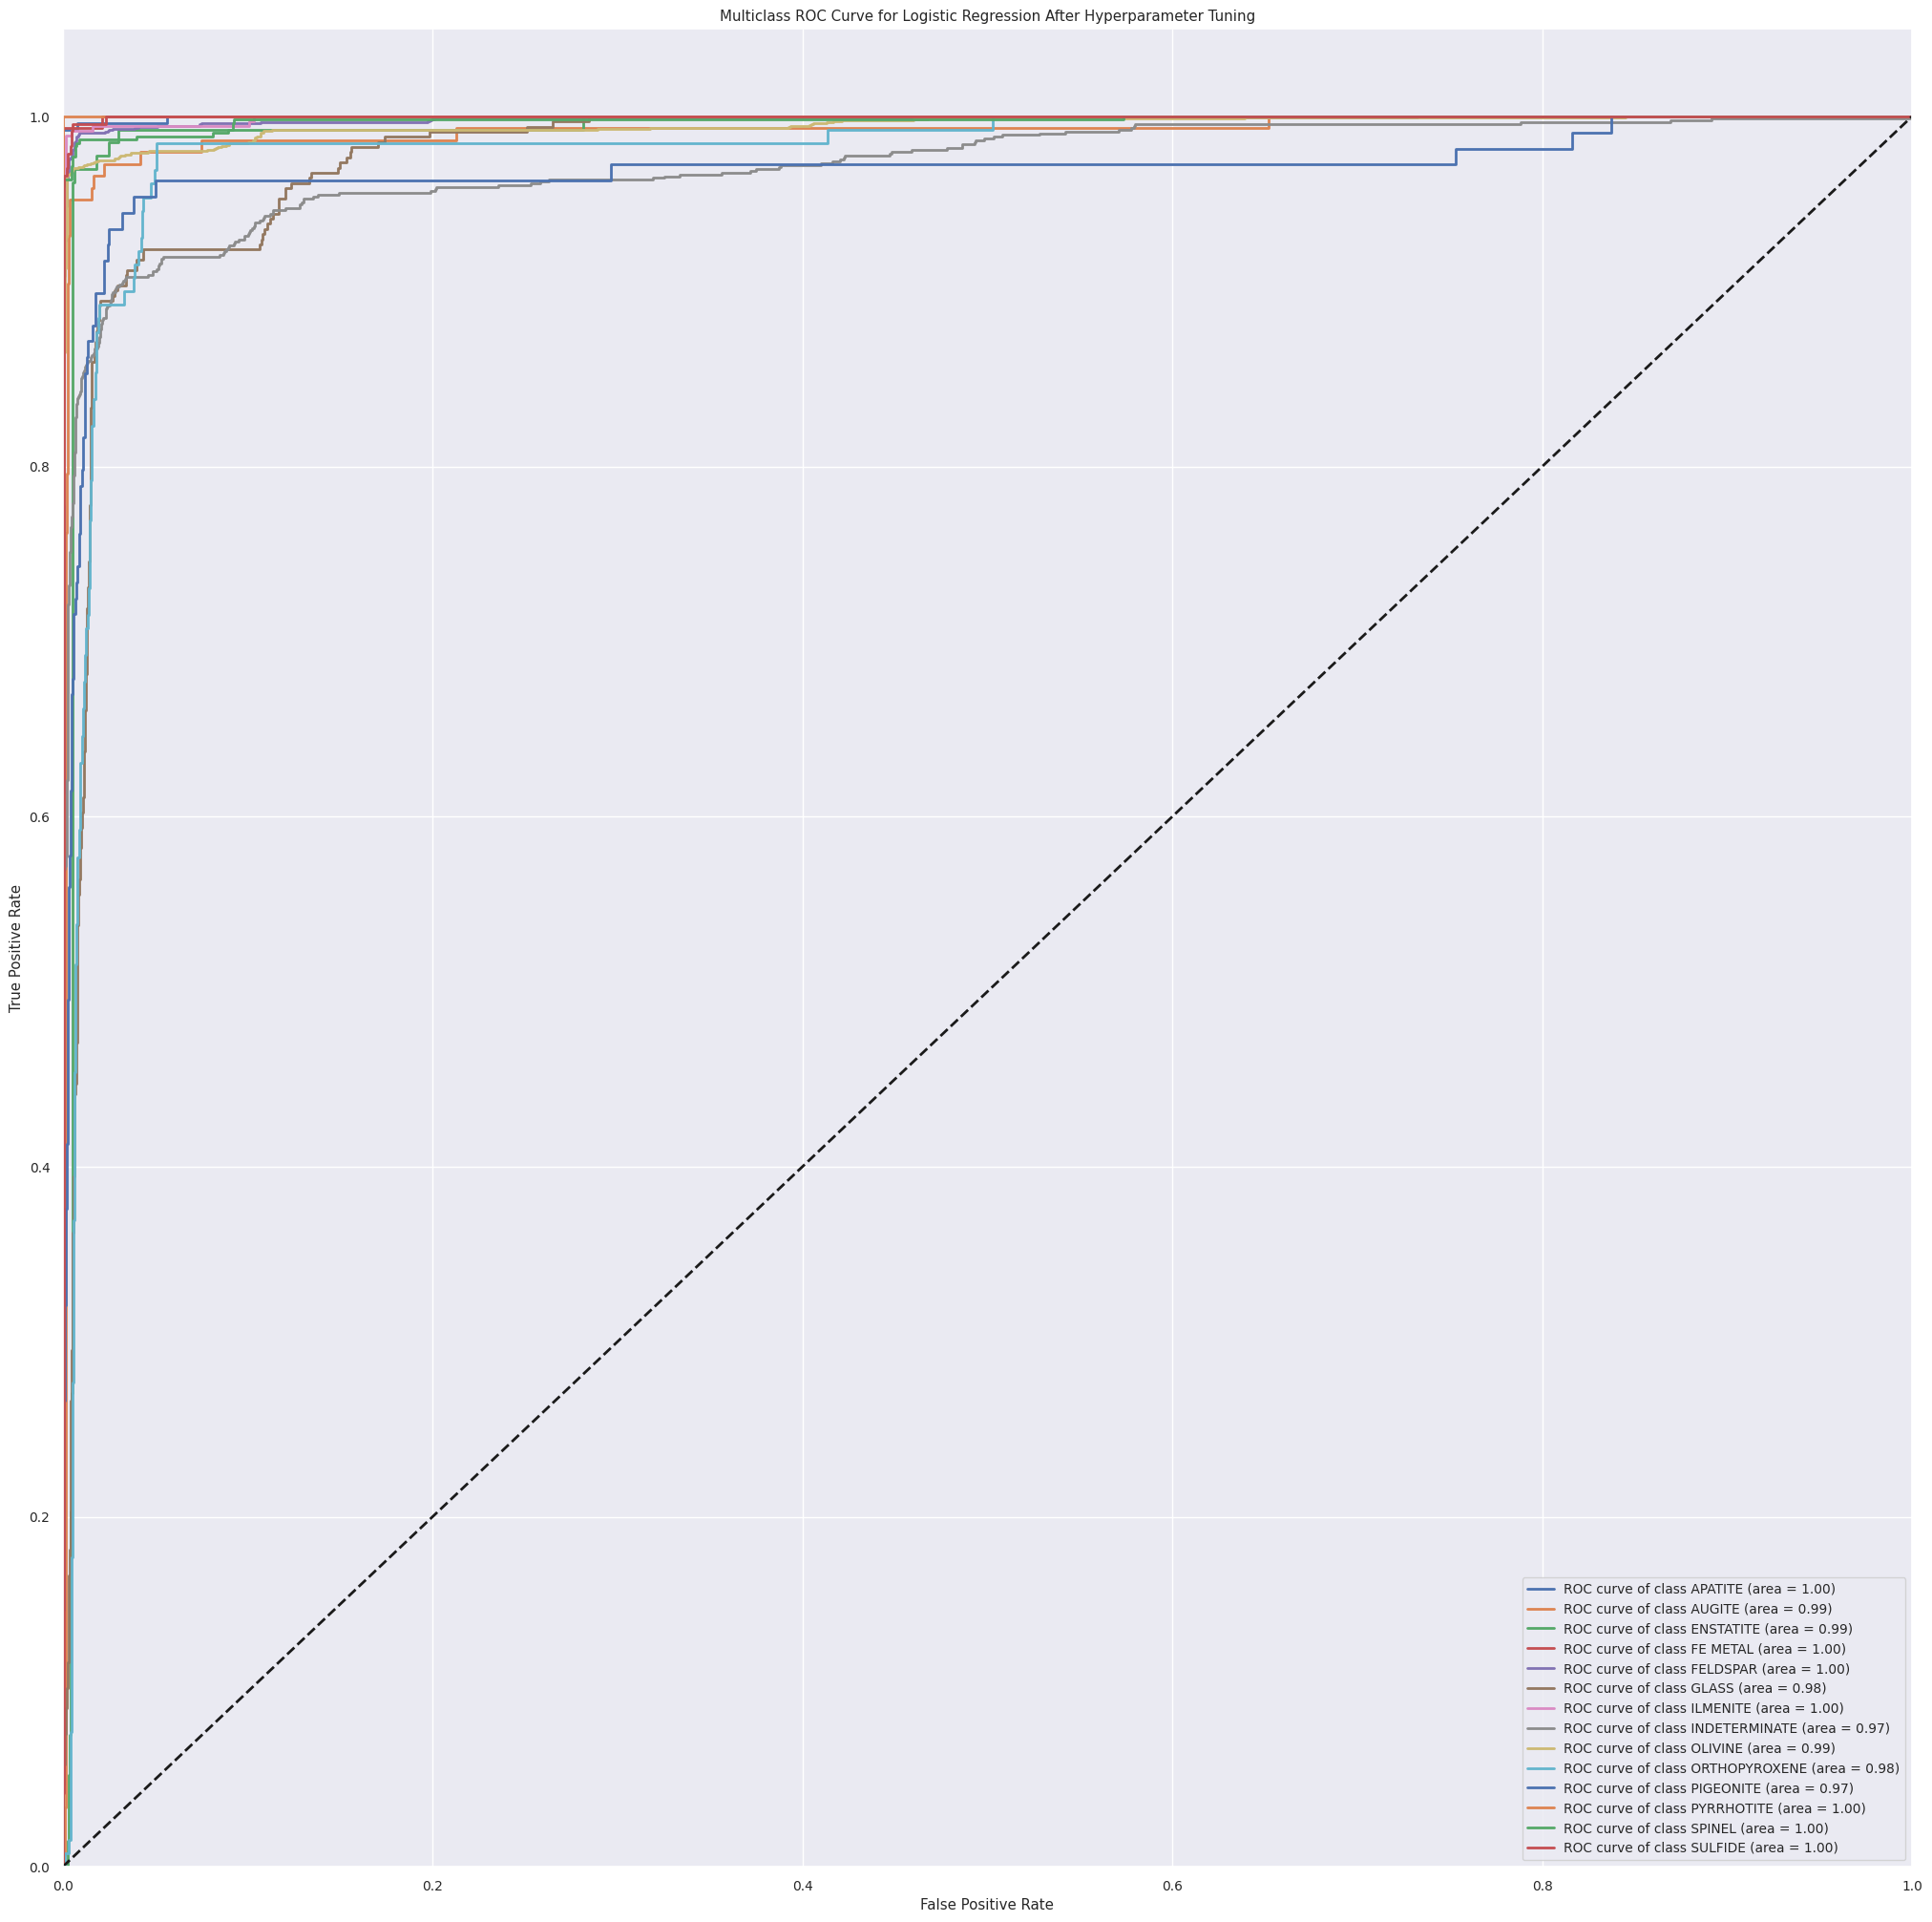

In [26]:
y_test_bin = label_binarize(y_test, classes=list(class_name_mapping.values()))

# Get predicted probabilities for each class
y_pred_proba = logreg.predict_proba(X_test)

plot_roc_curve(y_test_bin, y_pred_proba, 'Logistic Regression After Hyperparameter Tuning')

### <p style="text-align:center;"><i>Figure 9: ROC curves and AUC calculations for the Logistic Regression model with tuned hyperparameters</i></p>

In [27]:
display_metrics(y_test, y_pred, classes, 'Logistic Regression after Hyperparameter Tuning')


-------------------- Logistic Regression after Hyperparameter Tuning Key Metrics --------------------

Accuracy: 0.93
Balanced Accuracy: 0.84

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.86
Macro Recall: 0.84
Macro F1-score: 0.84

Weighted Precision: 0.92
Weighted Recall: 0.93
Weighted F1-score: 0.92

--------------- Logistic Regression after Hyperparameter Tuning Classification Report ---------------

               precision    recall  f1-score   support

      APATITE       0.99      0.99      0.99       256
       AUGITE       0.83      0.88      0.86       147
    ENSTATITE       0.73      0.95      0.82       133
     FE METAL       1.00      0.99      1.00       147
     FELDSPAR       0.97      0.99      0.98      1773
        GLASS       0.73      0.54      0.62       342
     ILMENITE       0.97      0.98      0.98       372
INDETERMINATE       0.86      0.87      0.87       937
      OLIVINE       0.94      0.98      0.96      2963
ORTH

Comparing the first Logistic Regression model to the second, it appears that there has been a very slight improvement by using the resulting hyperparameters that can be seen in the confussion matrix. However, both models seemed to do poorly on glass, orthopyroxene and pigeonite predictions and are extremely similar.

## XGBoost Classifier

---

For the XGBoost classifier, I set the objective hyperparameter to softprob, as the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html) states "When used with multi-class classification, objective should be multi:softprob instead of multi:softmax, as the latter doesn’t output probability". For evaluation metrics I used merror which looks at Multiclass classification error rate and is calculated as #(wrong cases)/#(all cases). I also used the mlogloss which is the Multiclass logloss.

In [28]:
xgb_clf = xgb.XGBClassifier(objective='multi:softprob',
                            num_class=11,
                            missing=1,
                            learning_rate= 0.1,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train,
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_val, y_val)])



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=11, num_parallel_tree=None, ...)

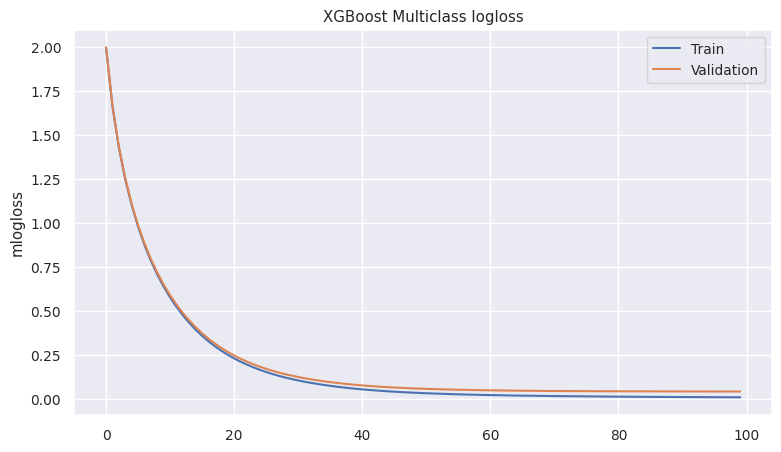

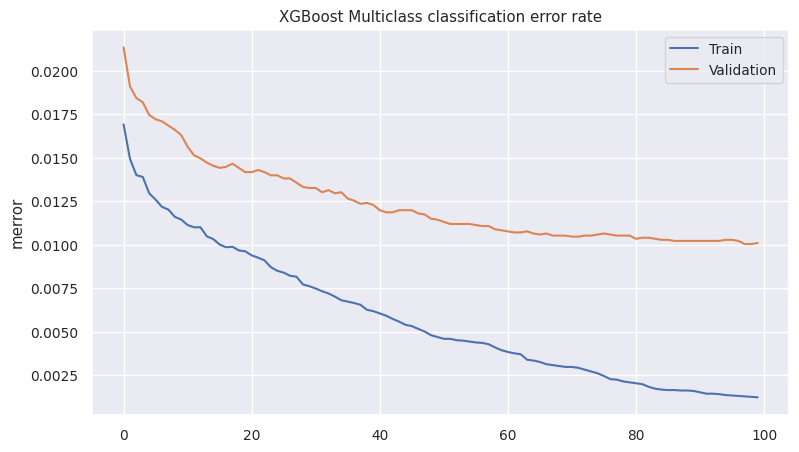

In [29]:
# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost Multiclass logloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost Multiclass classification error rate')
plt.show()


### <p style="text-align:center;"><i>Figure 10: Logloss and Multiclass classification error rate for XGBoost training</i></p>

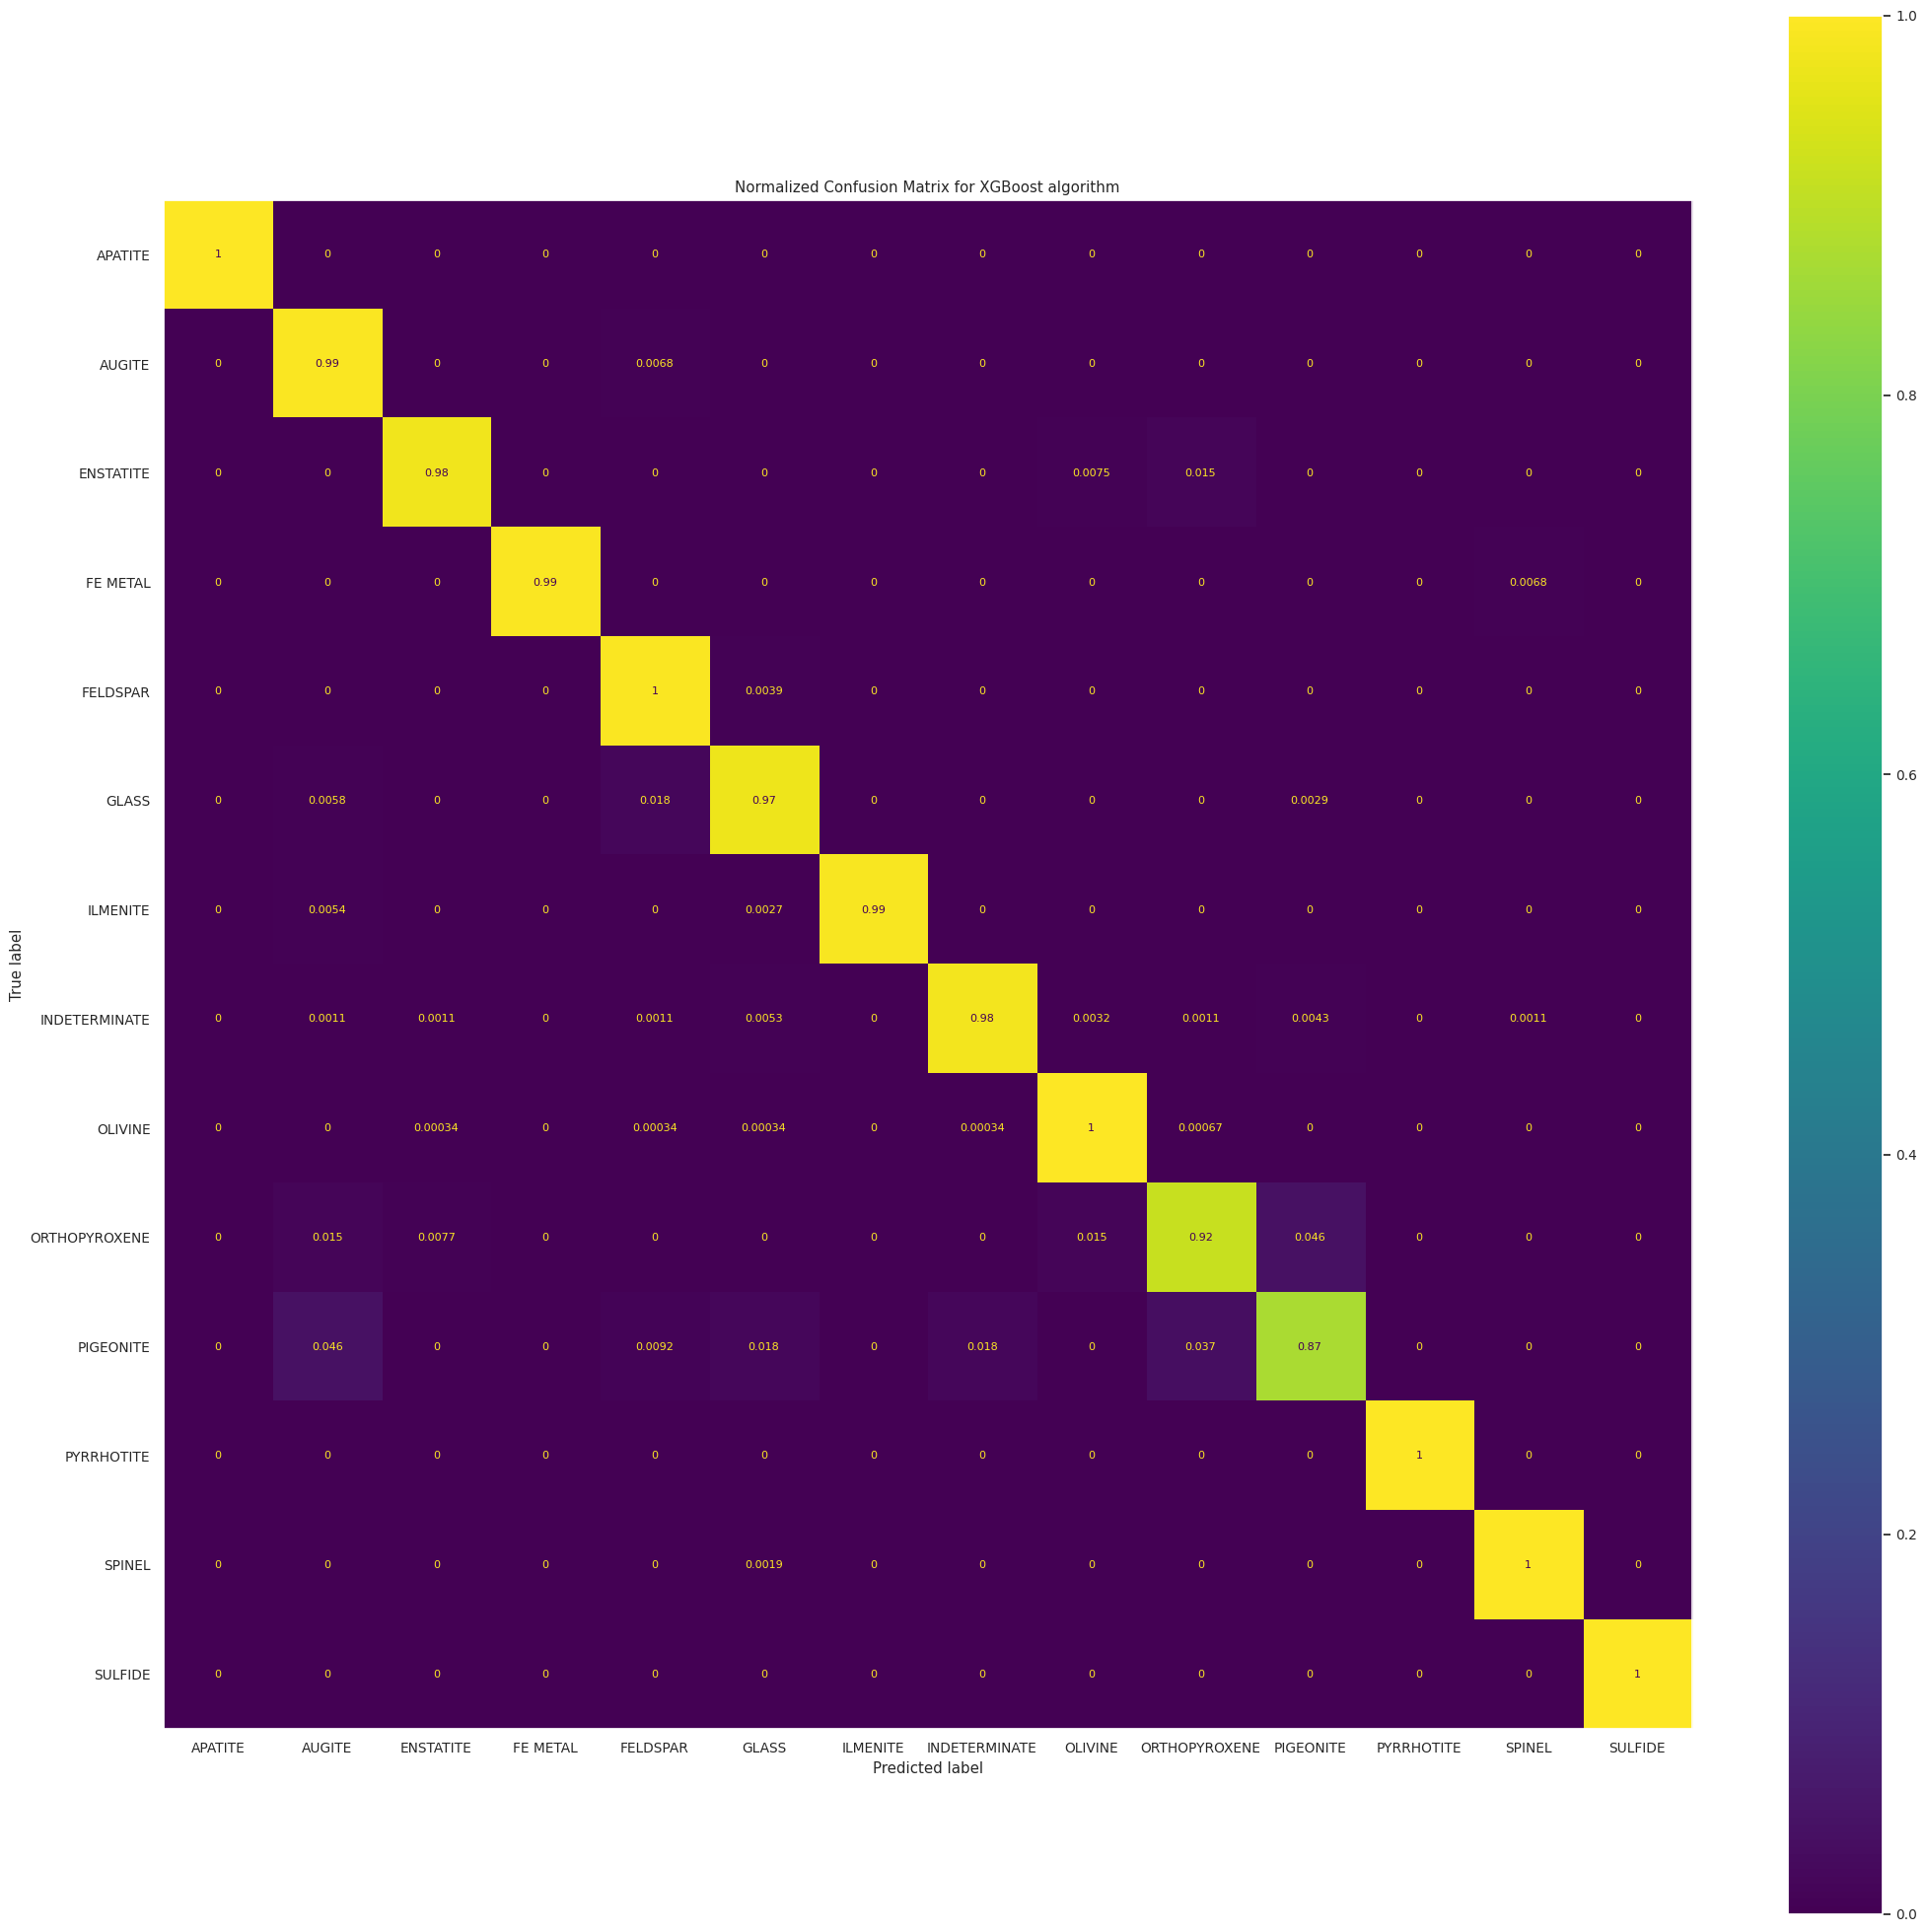

In [30]:
y_pred = xgb_clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, 'XGBoost')

### <p style="text-align:center;"><i>Figure 11: XGBoost confusion matrix. This model seemed to have issues with orthopyroxene and pigeonite, but still did very well at correctly classifying those samples.</i></p>

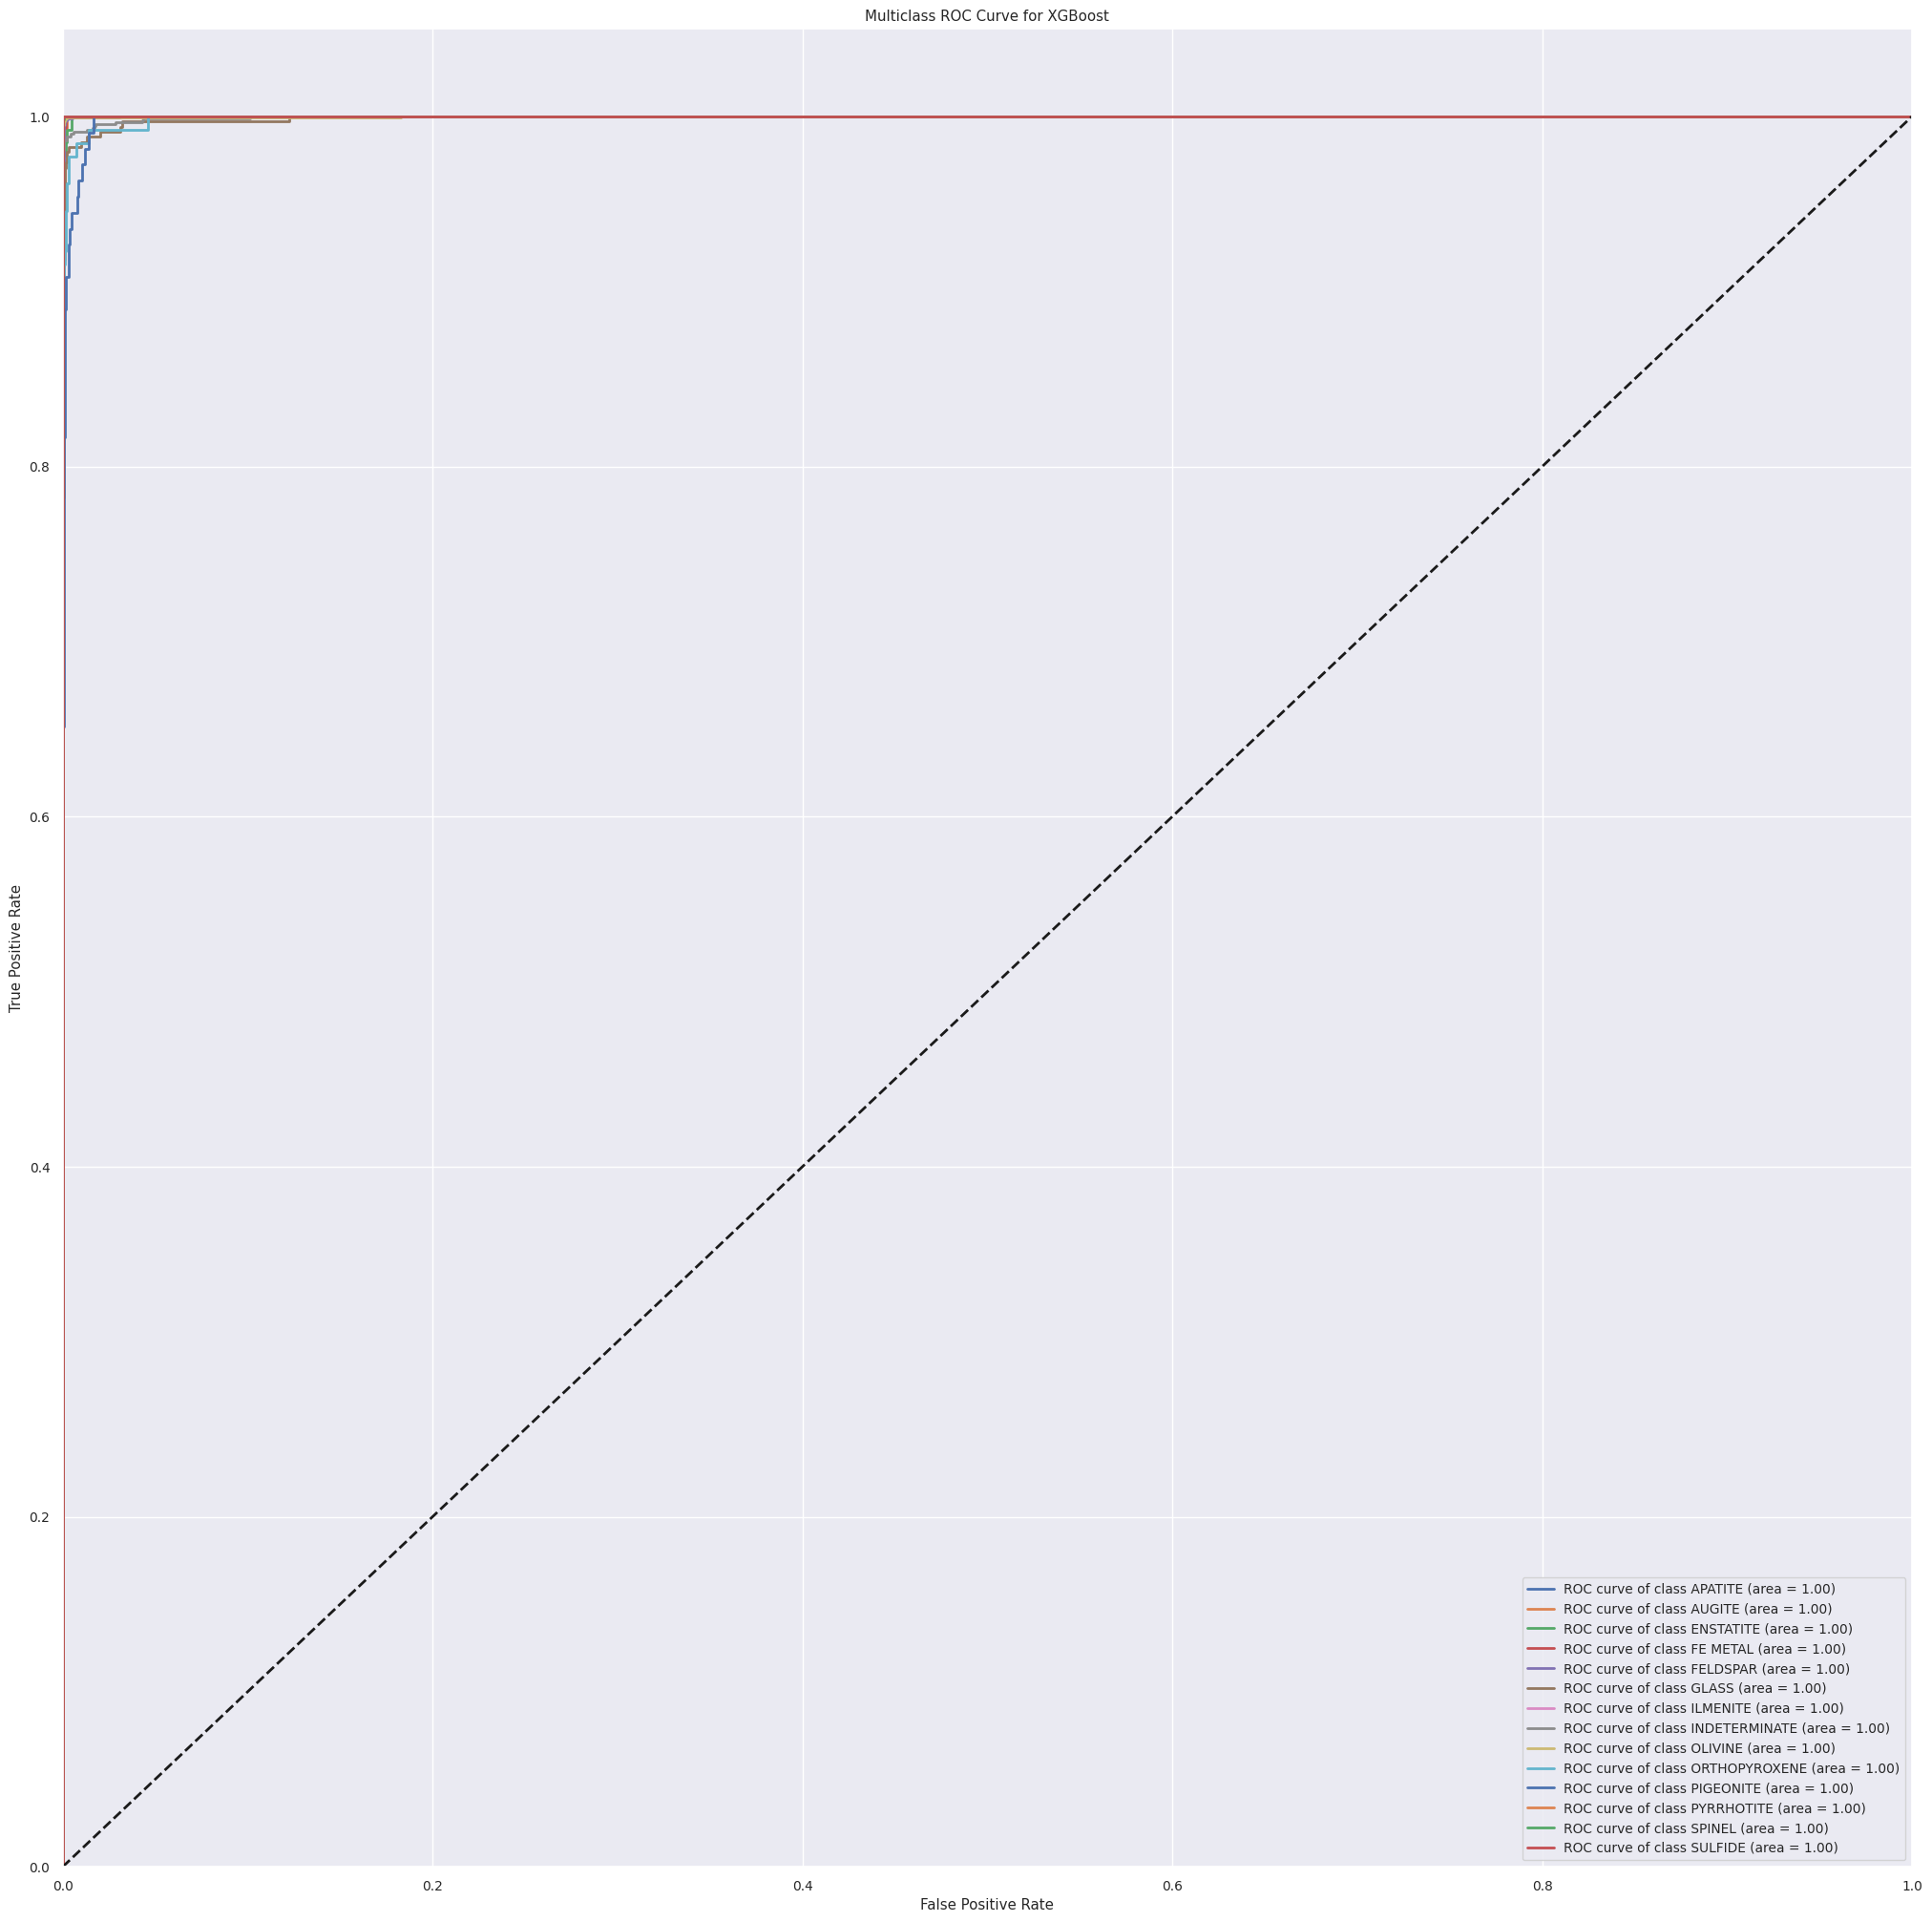

In [31]:
y_test_bin = label_binarize(y_test, classes=list(class_name_mapping.values()))

# Get predicted probabilities for each class
y_pred_proba = xgb_clf.predict_proba(X_test)

plot_roc_curve(y_test_bin, y_pred_proba, 'XGBoost')

### <p style="text-align:center;"><i>Figure 12: ROC curves and AUC calculations for the XGBoost model.</i></p>

In [32]:
display_metrics(y_test, y_pred, classes, 'XGBoost')


-------------------- XGBoost Key Metrics --------------------

Accuracy: 0.99
Balanced Accuracy: 0.98

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.98
Macro Recall: 0.98
Macro F1-score: 0.98

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- XGBoost Classification Report ---------------

               precision    recall  f1-score   support

      APATITE       1.00      1.00      1.00       256
       AUGITE       0.92      0.99      0.96       147
    ENSTATITE       0.98      0.98      0.98       133
     FE METAL       1.00      0.99      1.00       147
     FELDSPAR       0.99      1.00      1.00      1773
        GLASS       0.95      0.97      0.96       342
     ILMENITE       1.00      0.99      1.00       372
INDETERMINATE       1.00      0.98      0.99       937
      OLIVINE       1.00      1.00      1.00      2963
ORTHOPYROXENE       0.93      0.92      0.92       130
    PIGEONITE       0.90     

## MLP Classifier using Keras


---

I performed a split of the data again, because the neural network expects the target variable to be one-hot encoded. I also applied the scaling to the train, test and validation sets as I did before. I created a pretty shallow network, with only 3 hidden layers. I have had good luck with the Rectified Linear Unit (ReLU) activation function in the past, so I used that for the input and hidden layer, and then softmax for the output layer. I also utilized Adam as my optimizer and categorical crossentropy for the loss function as these have provided me with good results in the past with multiclass classification.

In [33]:
# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_ohe, test_size=0.3, stratify=y_ohe, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Create StratifiedShuffleSplit object
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform stratified splitting
for train_index, val_index in stratified_splitter.split(X, y_ohe):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_ohe[train_index], y_ohe[val_index]


In [34]:
#Standardize the feature vectors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [35]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(8,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [50]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9727 - loss: 0.0977 - val_accuracy: 0.9725 - val_loss: 0.1111
Epoch 2/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9722 - loss: 0.0961 - val_accuracy: 0.9748 - val_loss: 0.0987
Epoch 3/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9743 - loss: 0.0880 - val_accuracy: 0.9749 - val_loss: 0.0971
Epoch 4/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9742 - loss: 0.0907 - val_accuracy: 0.9721 - val_loss: 0.1106
Epoch 5/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9744 - loss: 0.0868 - val_accuracy: 0.9746 - val_loss: 0.0996
Epoch 6/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9747 - loss: 0.0873 - val_accuracy: 0.9722 - val_loss: 0.1074
Epoch 7/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9746 - loss: 0.0877 - val_accuracy: 0.9755 - val_loss: 0.1011
Epoch 8/10
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9762 - loss: 0.0846 - 

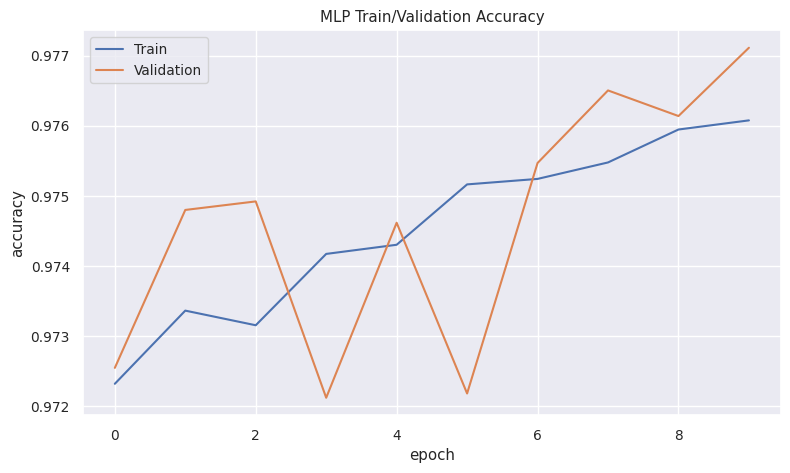

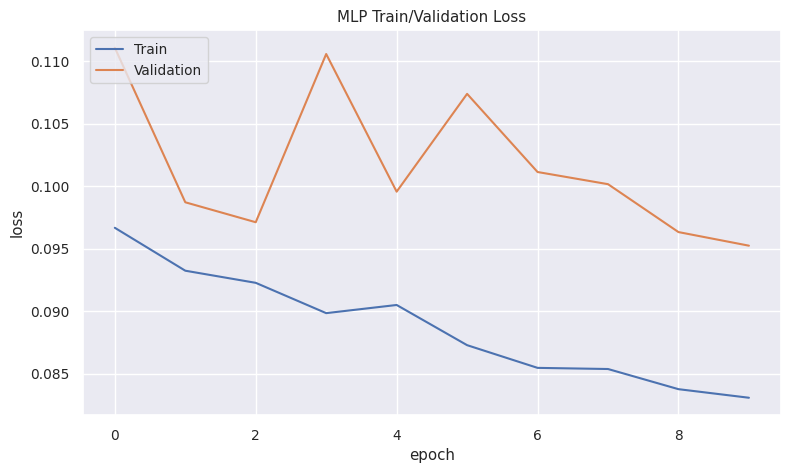

In [51]:
epochs = len(history.history['accuracy'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, history.history['accuracy'], label='Train')
ax.plot(x_axis, history.history['val_accuracy'], label='Validation')
ax.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title('MLP Train/Validation Accuracy')
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, history.history['loss'], label='Train')
ax.plot(x_axis, history.history['val_loss'], label='Validation')
ax.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title('MLP Train/Validation Loss')
plt.show()

### <p style="text-align:center;"><i>Figure 13: Visual inspection of the accuracy and loss plots shows that the model may be overfitting, as the  training loss is lower than your validation loss. It appears that convergence occurs at 3 epochs. I will address this in the final submission.</i></p>

In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test)

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9767 - loss: 0.0976


In [53]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1)



257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


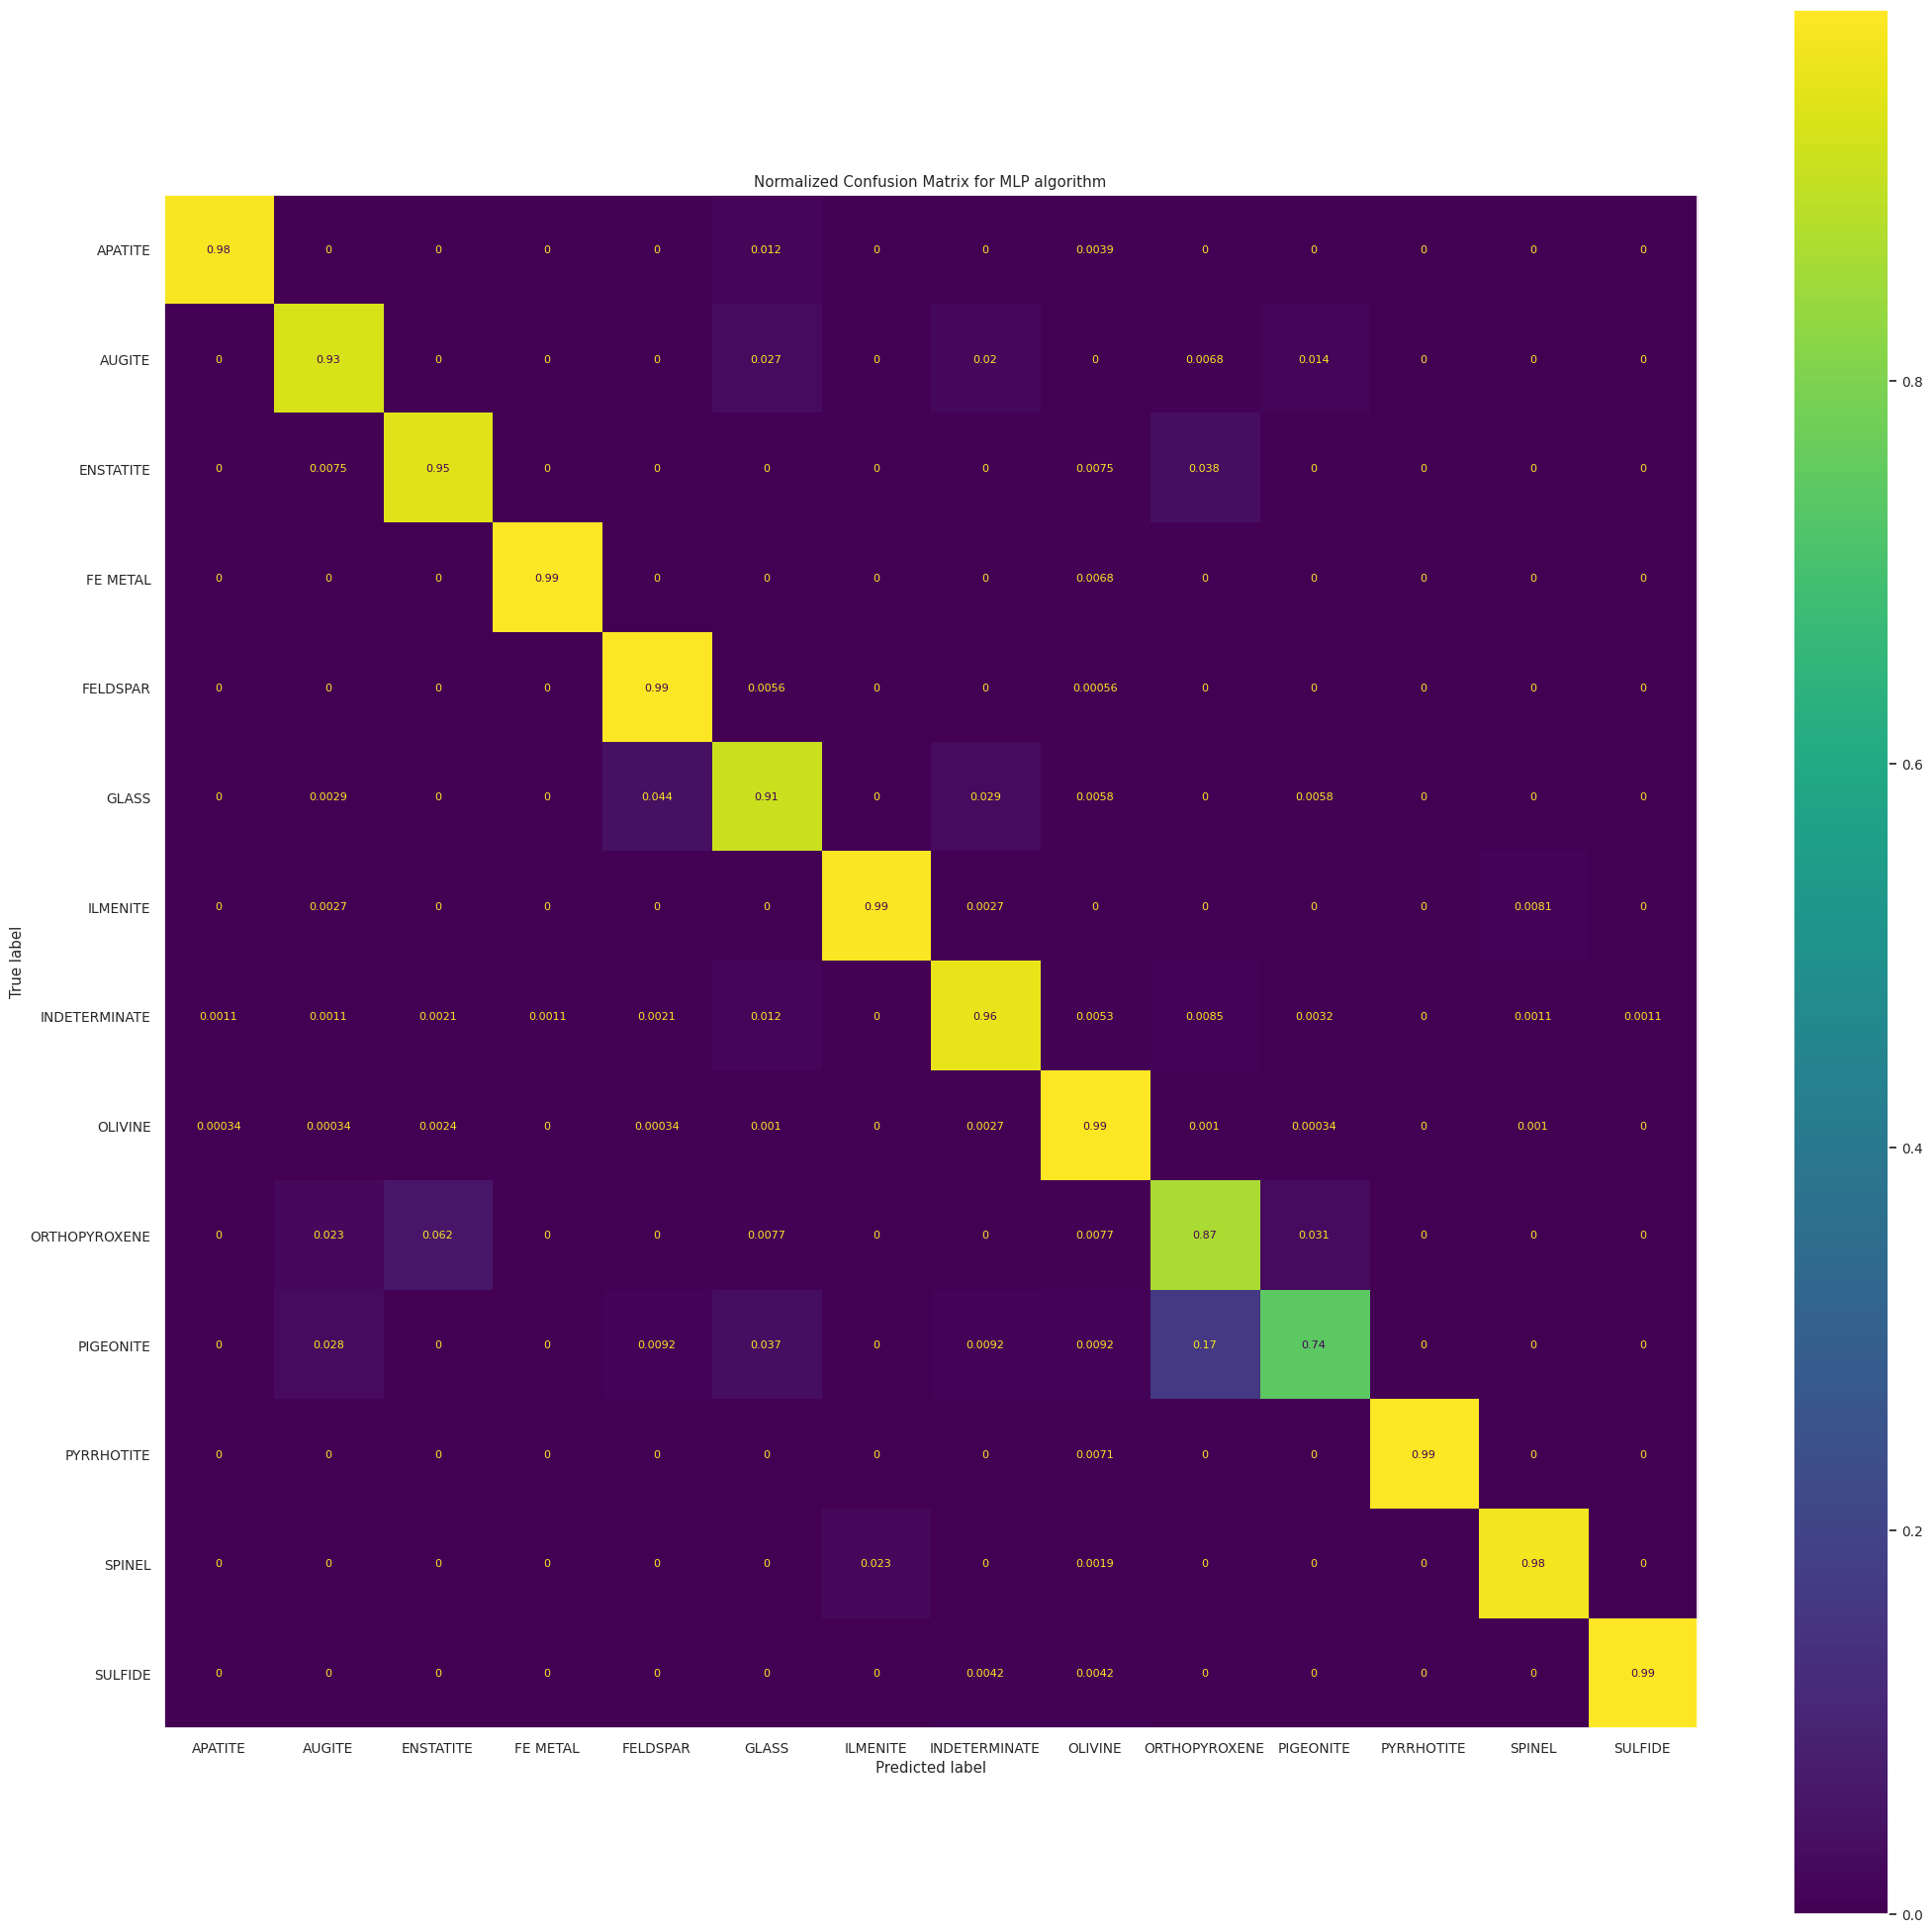

In [54]:
# Compute and plot the confusion matrix
plot_confusion_matrix(Y_true, Y_pred_classes, 'MLP')

### <p style="text-align:center;"><i>Figure 14: The MLP model did well, but did have some issue with pigeonite where a fair amount of the samples were classified as orthopyroxene. These minerals are extremely similar, so this might why those smaples wer misclassified. The MLP did have issues classifying glass properly some of the time, just like the other models.</i></p>

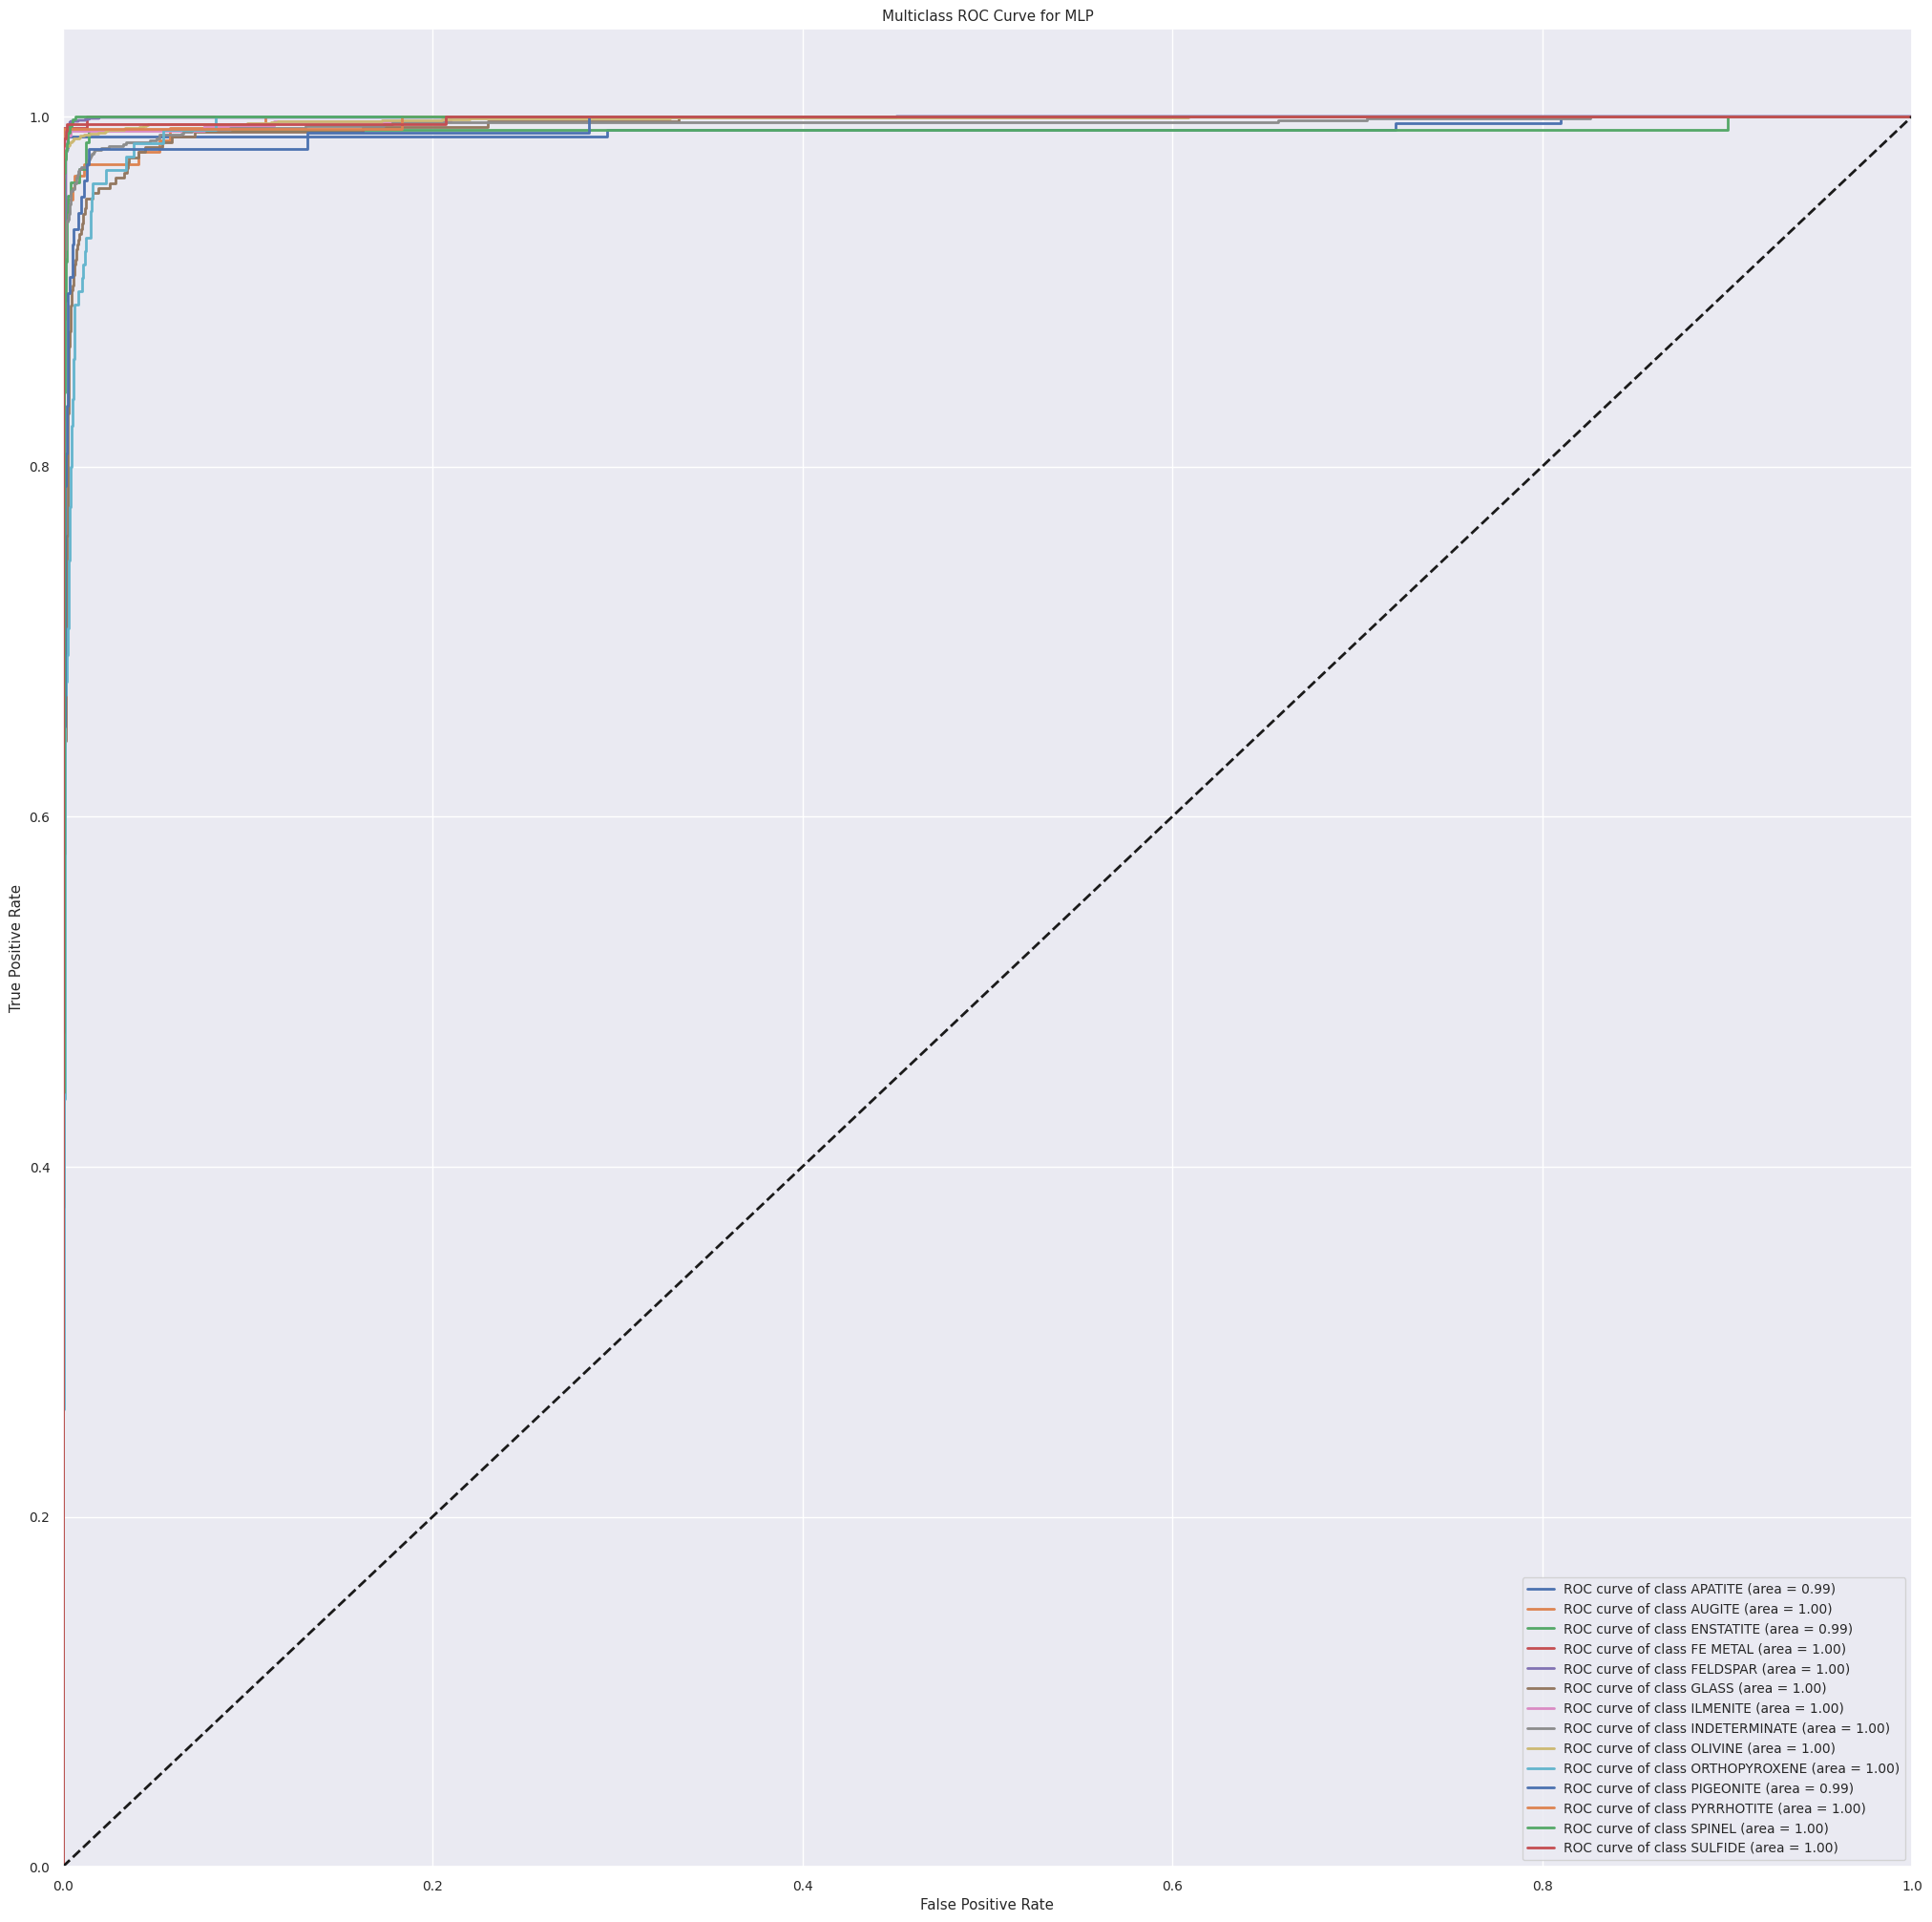

In [42]:
plot_roc_curve(y_test, Y_pred, "MLP")


### <p style="text-align:center;"><i>Figure 15: MLP ROC curves and AUC calulations.</i></p>

In [43]:
display_metrics(Y_true, Y_pred_classes, classes, 'MLP')


-------------------- MLP Key Metrics --------------------

Accuracy: 0.97
Balanced Accuracy: 0.94

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.93
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97

--------------- MLP Classification Report ---------------

               precision    recall  f1-score   support

      APATITE       0.99      0.98      0.99       256
       AUGITE       0.91      0.93      0.92       147
    ENSTATITE       0.84      0.95      0.89       133
     FE METAL       0.99      0.99      0.99       147
     FELDSPAR       0.98      1.00      0.99      1773
        GLASS       0.91      0.85      0.88       342
     ILMENITE       0.97      0.99      0.98       372
INDETERMINATE       0.97      0.95      0.96       937
      OLIVINE       1.00      0.98      0.99      2963
ORTHOPYROXENE       0.74      0.84      0.79       130
    PIGEONITE       0.86      0.79   

## Conclusion

---

All 3 classifiers did exceedingly well on most classes, although the XGBoost model did stand out as the clear winner. Relabeling of like classes certainly seemed to help, as well as dropping the more generic pyroxene samples. Hyperparameter tuning for Logistic Regression models did little to improve them. I was high impressed with the XGBoost classifier, as no tuning was performed and the classifier was spot-on, doing well on all classes except for hiccups with pigeonite and orthopyroxene. The MLP model turned out good as well, although as Thomas pointed out in my post, XGBoost would be the algorithm to use considering how small my data set is. Outlier removal didn't really seem to have an impact overall. Feature importnat analysis was also performed with the Random Forest Classifier and showed that AL2O3 was the most important feature in the data set. I also introduced a more robust data validation and loading procedure, to ensure that the data is loaded in correctly.

## Answers to Questions

---


- **Which method did you like the most?**
#### From a results, ease of use and explainability standpoint, I liked XGBoost the most. I have taken an  NVIDIA training course that used XGBoost for Anomaly Detection, but getting to utilize it with a dataset of my choosing for classification was cool and I was very happy with the results of this algorithm.
- **Which method did you like the least?**
#### Logistic Regression gave the worst results, so this is the reason why I liked this algorithm the least. I also had a hard time determining how to capture the loss and accuracy for each epoch of the Logistic Regression training.

- **How did you score these supervised models?**
#### To score these algorithm I used confusion matrices, ROC/AUC curves, and classification reports.

- **Did the output align with your geologic understanding?**
#### As I don't have a strong background in geology, I had to do some research to determine information about minerals. I removed the generic pyroxene samples which I believe is the reason that some samples were being misclassified. I also relabeled plagioclase and maskelynite to feldspar to ensure that these samples to help with the previous misclassifications
- **Did you hyperparameter tune? Why or why not?**
#### I performed hyperparameter tuning on my Logistic Regression clssifier, which didn't really help improve performance. XGBoost got extremely good results, as did the MLP, so I didn't utilize any hyperparameter tuning for those classifiers.
- **How did you split your data? and why does that make sense for this dataset?**
#### Because of the class imbalance that exisits in the data, I performed a Stratified Split of the data. I believe this was a good method to choose, as stratified splitting is important to maintain a consistent class distribution across training, validation, and test sets.
- **What did you want to learn more about?**
#### I applied hyperparameter tuning for Logistic Regression in addition to  using the "vanilla" algorithm. If I were to do more work on that classifier, I might consider the use of another means of tuning as the Grid Search does not utilize the GPU and is extremely slow.
- **Did you pre-process your data?**
#### I did a fair amount of pre-processing during EDA including dropping rows with NAN's and converting the data to tehe correct data type. In this notebook I encoded the classes using a label encoder and then one-hot encoded the class targets for the neural network. I also fit a standard scaler to the training data and then transformed the validation and test sets with the same scaler that was fit to the training data to prevent introducing bias.I also removed the outliers before performing imputation to try to increase performance.
- **Do all models require pre-processing?**
#### Yes, all the models require pre-processing, as the target variables need to be converted to integers in order to perform model training.

## References


---


### https://www.skyatnightmagazine.com/advice/skills/see-apollo-landing-sites-moon